In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions

from importlib import reload

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_seconds = 86400

## Looking for ETVs in TIC 88996391

- target with clear eclipse depth variations, possibly due to a 3rd body.
- eclipses disappeared in sectors 79, 80
- known SB1 with a period of ~246 d per [Gaia DR3 NSS](https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ654d41d6a6ba&-out.add=.&-source=I/357/tbosb1&recno=131435&-out.orig=o), suggesting a 3rd body

In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid = 88996391

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../


sr = lk.search_lightcurve('TIC {}'.format(ticid)) 
sr = lke.filter_by_priority(sr, author_priority=['SPOC'], exptime_priority=['short', 'long', 'fast'])  # 'SPOC', 'TESS-SPOC', 'QLP'
sr = sr[sr.table["sequence_number"] <= 53]  # data in sectors 79, 80 show no dip
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
with astropy.conf.set_temp("max_lines", -1):
    display(sr)
lcc_tess = sr.download_all()

def use_sap_flux(lc):
    """Helper over select_flux("sap_flux") to ensure flux_err is populated for QLP case"""
    if lc.meta.get("AUTHOR") == "QLP":
        # select_flux("sap_flux") on QLP data will lead to nan flux_err
        # because QLP lc only has err on kspsap_flux / det_flux
        return lc
    else:
        return lc.select_flux("sap_flux")

lc_tess = lcc_tess.stitch(
    # corrector_func=lambda lc: use_sap_flux(lc).normalize()
)
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 4 data products.

 #     mission     year author exptime target_name distance     proposal_id     
                                  s                 arcsec                      
--- -------------- ---- ------ ------- ----------- -------- --------------------
  0 TESS Sector 25 2020   SPOC     120    88996391      0.0              G022253
  1 TESS Sector 26 2020   SPOC     120    88996391      0.0              G022253
  2 TESS Sector 52 2022   SPOC     120    88996391      0.0 G04039_G04157_G04242
  3 TESS Sector 53 2022   SPOC     120    88996391      0.0 G04039_G04157_G04242

64142

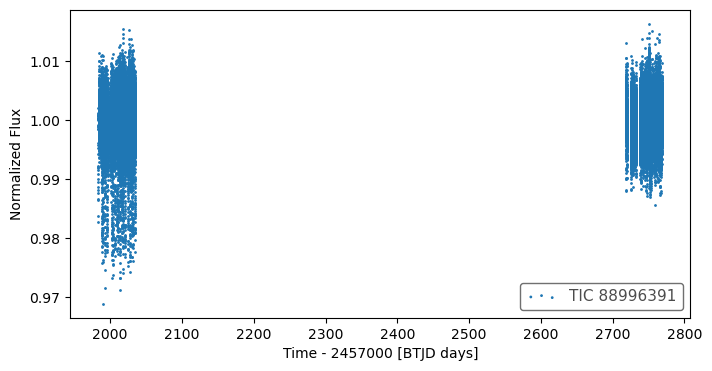

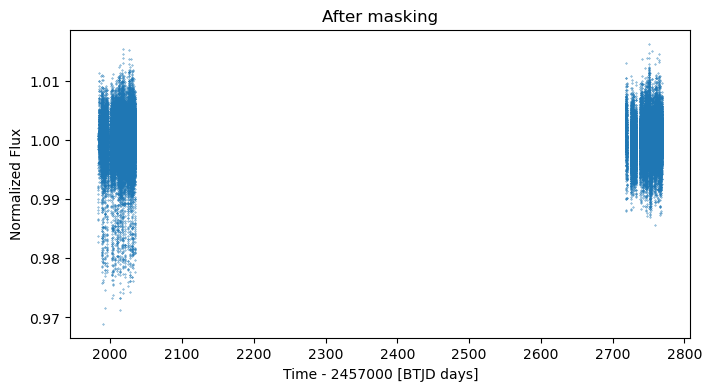

In [5]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data
# mask = flux < 0.85    # remove occasional outliers
# mask = (
#     ( flux < 0.75 ) | # remove  outliers
#     ( flux > 1.07 )  # remove  outliers
# )

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [6]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [7]:
do_ls = False

if do_ls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg as lke_pg  # at ../../

    lc = lk.LightCurve(time=Time(time, format="btjd"), flux=flux, flux_err=fluxerr)
    lc.meta["LABEL"] = f"TIC {ticid}"
    pg = lc.to_periodogram(method="lombscargle",
                           # maximum_period=10,
                           # minimum_period=0.4,
                           # ls_method="fastchi2", nterms=2,
                           # oversample_factor=50,  # default: 5
                          )

    pg.show_properties();
    print(pg.period_at_max_power);

    ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=10);

    ax = pg.plot(view="frequency");  # frequency view
    ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

    ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");

    axs, lcs = lke_pg.plot_lc_with_model(
        lc,
        pg,
        plot_lc=False, plot_model=False, plot_folded_model=True,
        also_return_lcs=True);


In [8]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

### Define epoch, period, duration

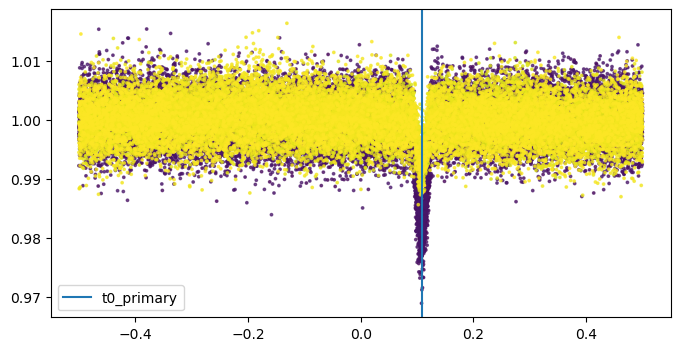

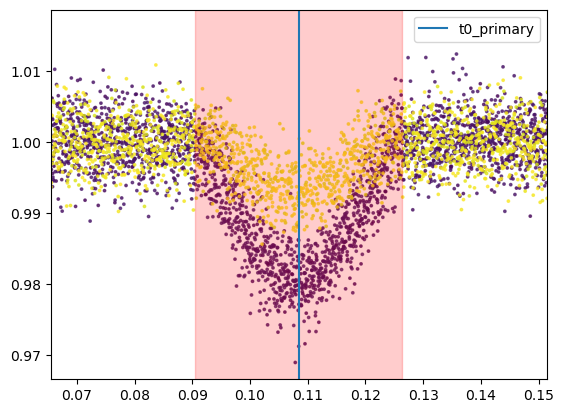

In [9]:
%matplotlib inline
# %matplotlib widget

# define the orbital period and the t0

# epoch=1985.9468, duration_hr=1.48586, period=2.31976, label="s0014s0055tce1", transit_depth_percent=1.3692,
# MCMC on df_primary (narrow clipped LC): p: 2.3194994747116384, std_p: 2.276329329220973e-05 ;  t0: 1985.951032828567, std_t0: 0.0003521505900199191
# MCMC on df_primary (wide clipped LC):   p: 2.3197384476282403, std_p: 1.6466859666378338e-06 ; t0: 1985.948828313677, std_t0: 0.0002829432982966971


# FILL-IN THE eclipse epoch / period,
# period = 2.31976  # TCE1
# period = 2.3195 # MCMC (narrow)
period = 2.31974  # MCMC (wide) 

# t0_primary = 1985.947  # TCE1
# t0_primary = 1985.951  # MCMC (narrow)
t0_primary = 1985.949  # MCMC (wide)

t0_secondary = None

duration_hr_primary = 2.0  # visual
# duration_hr_secondary = 

# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
# if t0_secondary is not None:  # the adjustment is counter productivfe due to custom period for secondary
#     t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

t0_for_plotting = 0  # keep 0 for plotting purposes
if t0_secondary is not None:
    t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.9, 1.04);
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.9, 1.04);
plt.show()

# seconary plot not helpful as the period is different
if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    plt.ylim(0.95, 1.03);
    plt.show()

### Compare folded plots across sectors

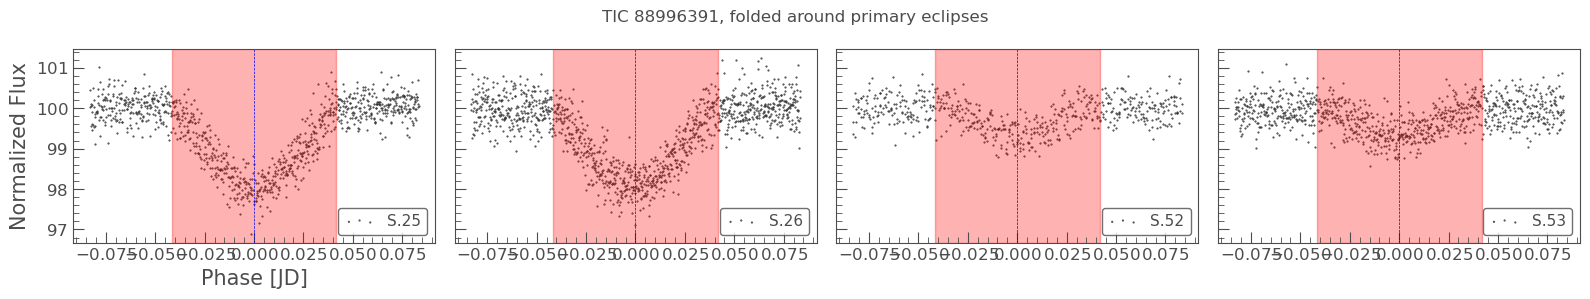

In [34]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 1 / 24, duration_hr_primary * 1 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.axvline(0, color="blue", linestyle="--");
        ax.axvspan(-duration_hr_primary * 0.5 / 24, duration_hr_primary * 0.5 / 24, color="red", alpha=0.3);
        ax.legend(loc="lower right");
        if i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# # ---
# with plt.style.context(lk.MPLSTYLE):
#     fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
#     if isinstance(axs, plt.Axes):
#         axs = [axs]
#     for i, lc in enumerate(lcc_tess):
#         lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
#         lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
#         ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
#         ax.legend(loc="lower right");
#         if i > 0:
#             ax.set_ylabel(None)
#             ax.set_xlabel(None)
#     fig.suptitle(f"{lc.label}, folded around secondary eclipses");
# plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
data["flux_original"] = data.flux  # save the original flux 

In [ ]:
# show data to visualize what's changed in each step below
data

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

In [ ]:
# # Uncomment to use the detrended flux
# #
# print("Use deterended flux")
# data.flux = data.flux_detrended

### Now that the data is ready we can start 

- generally the clipped LC window is ***smaller*** than the eclipse duration, to avoid the complication of fitting ingress/egress.

In [10]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 2.0 * duration_hr_primary / 24 / period   # avoid ingress/egress, especially as the OOT data shows clear rise (probably tidal related)
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


# if t0_secondary is not None:
#     midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
#     print('Secondary:', t0_secondary, midpoint_s)

#     # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
#     window_width_s = 0.8 * duration_hr_secondary / 24 / period
#     # window_width_s = 0.22
#     print("window_width_s (phase):", window_width_s)

#     data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
#     ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V)
# t0 in normalixed phase

start_vals = [1.000, -0.01304, midpoint_p, 0.00820, 1.2674]
# start_vals_s = None

# -- -- -- -- -- -- -- -- --
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
# if t0_secondary is not None:
#     # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
#     etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, {t0_primary}, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   1985.949 0.10844318759869132
window_width_p (phase): 0.07184713229356163


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Start params for  fitting period with MCMC on df_primary:
[1.0, -0.01304, 1985.949, 0.0082, 1.2674, 2.31974],


In [ ]:
if False:
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 4000/4000 [08:25<00:00,  7.91it/s]


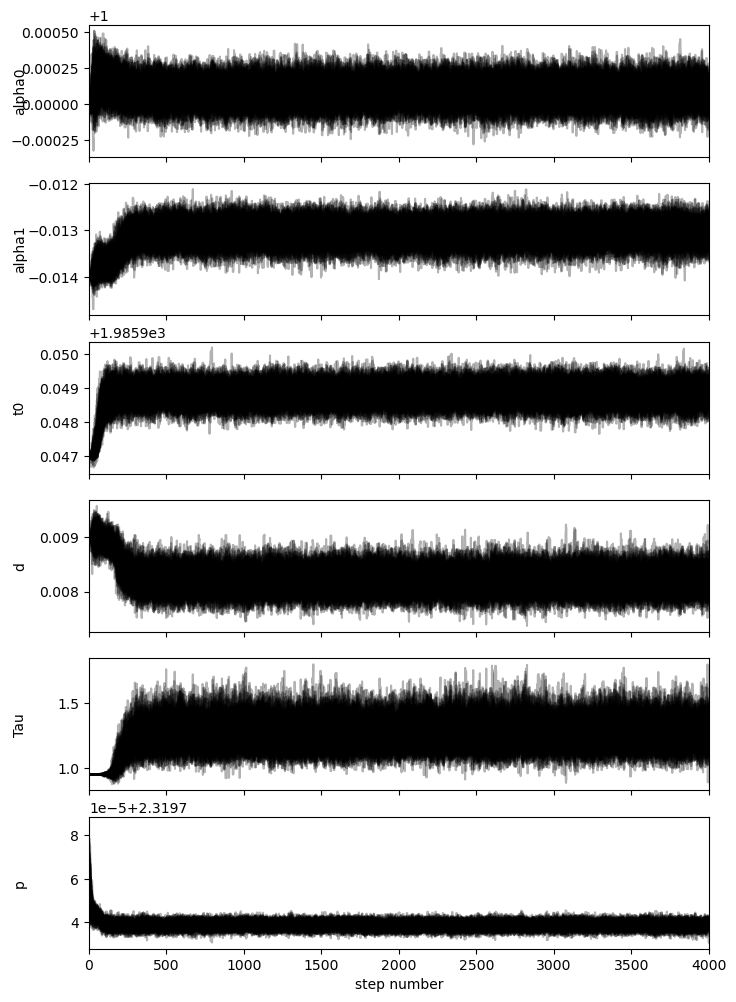

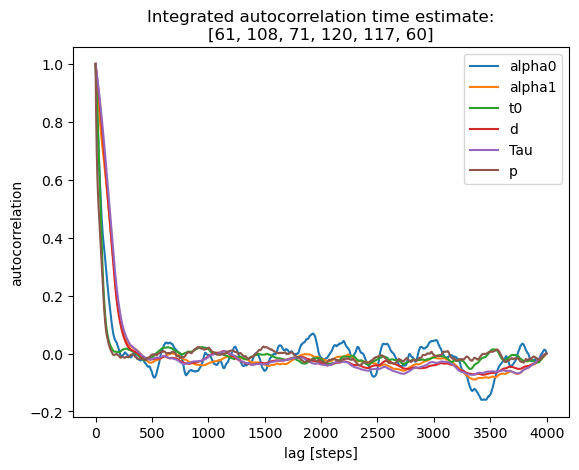

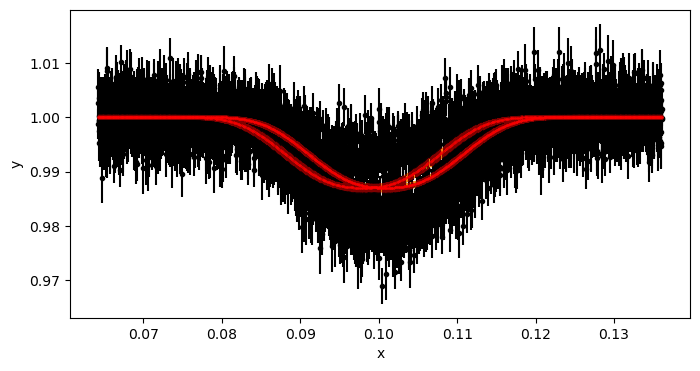

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0000816183662475, -0.01304687824142993, 1985.948828313677, 0.008200674614605195, 1.2673882507970569, 2.3197384476282403
std_p: 1.6466859666378338e-06 ; std_t0: 0.0002829432982966971


In [31]:
# use MCMC to refine the period

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()

    # MCMC result
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1.0, -0.014, 1985.947, 0.009, 0.95, 2.31976],
        # nruns=20, discard=1, # for a sanity test,  to ensure the initial guess is not way off.
        nruns=4000, discard=600,
        autocorr_time_kwargs=dict(tol=20),  # the emcee defaults tol=50 seems to be too strict for our use case, tol of ~10 - 20 seems to be sufficient
        pool=-2,
        plot_chains=True,
        plot_autocorrelation=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"], "; std_t0:", fit_params_p_stats['std_t0'])
    !$NOTIFY_CMD "Fitting period done."

In [ ]:
if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()

    # MCMC result
    mean_alpha0_s, mean_alpha1_s, mean_t0_time_s, mean_d_s, mean_Tau_s, mean_p, fit_params_s_stats = etvp.run_mcmc_initial_fit_p(
        data_secondary,
        [1.0, -0.011, 1686.61, 0.012, 1.2, 3.96518],
        # nruns=20, discard=1, # for a sanity test,  to ensure the initial guess is not way off.
        nruns=4000, discard=600,
        autocorr_time_kwargs=dict(tol=20),  # the emcee defaults tol=50 seems to be too strict for our use case, tol of ~10 - 20 seems to be sufficient
        pool=-2,
        plot_chains=True,
        plot_autocorrelation=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_time_s, mean_d_s, mean_Tau_s, mean_p = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_time_s, mean_d_s, mean_Tau_s, mean_p]]))
    print("std_p_s:", fit_params_s_stats["std_p"], "; std_t0_s:", fit_params_s_stats['std_t0'])
    !$NOTIFY_CMD "Fitting period (secondary) done."

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 4000/4000 [04:55<00:00, 13.56it/s]


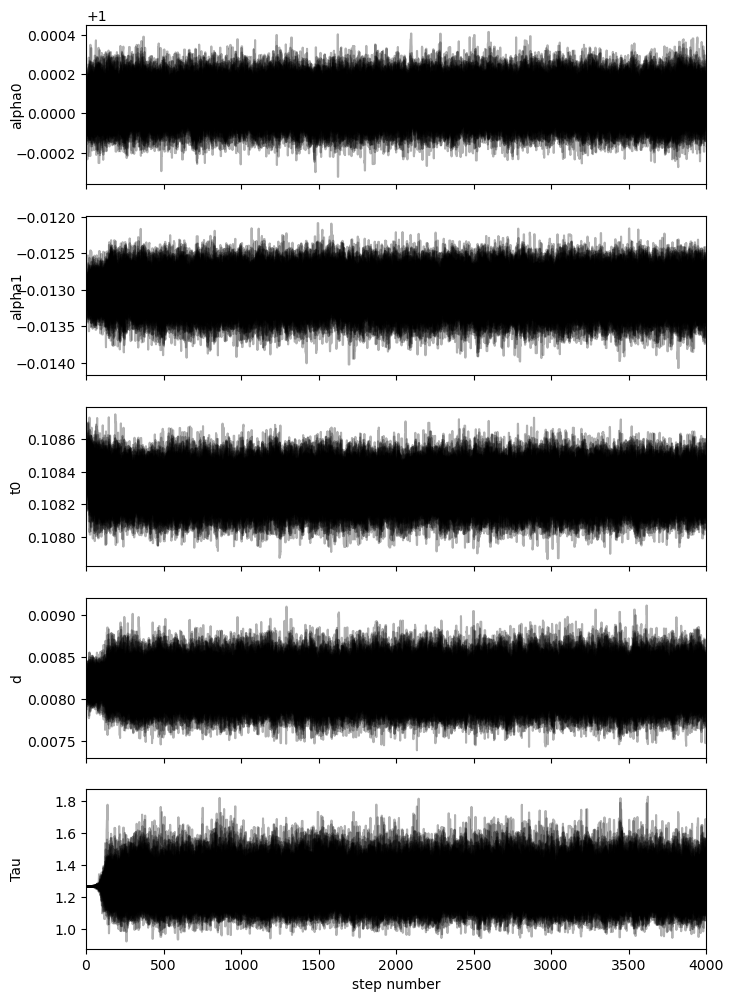

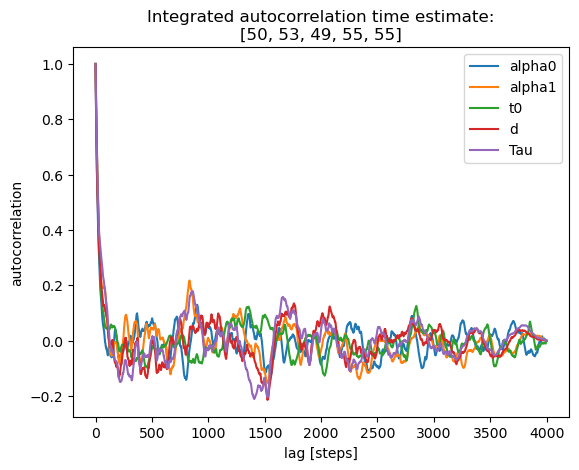

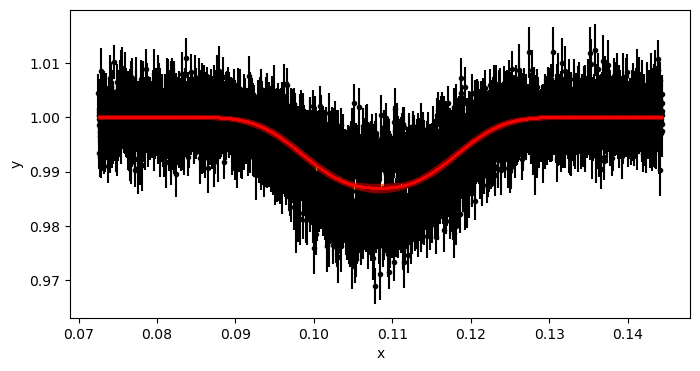

In [36]:
# run the initial model fit using MCMC for the primary and secondary eclipses
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, fit_params_stats = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns=4000, discard=600, autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)
    !$NOTIFY_CMD "Initial fit done"

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 4000/4000 [04:32<00:00, 14.68it/s]


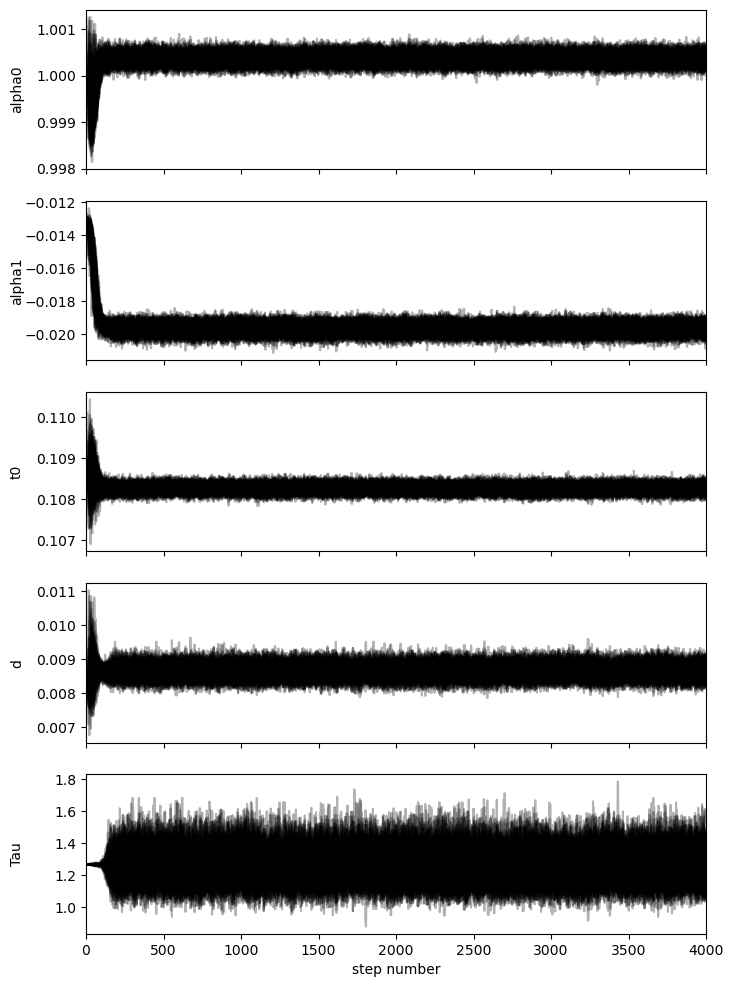

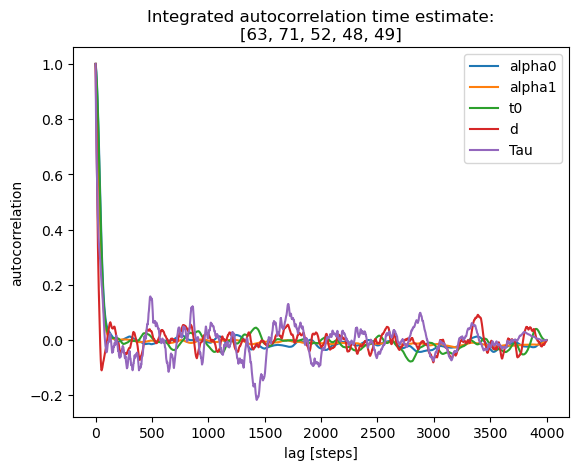

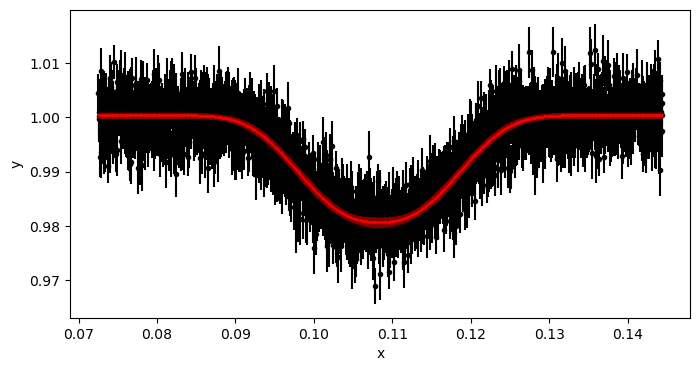

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 4000/4000 [04:24<00:00, 15.11it/s]


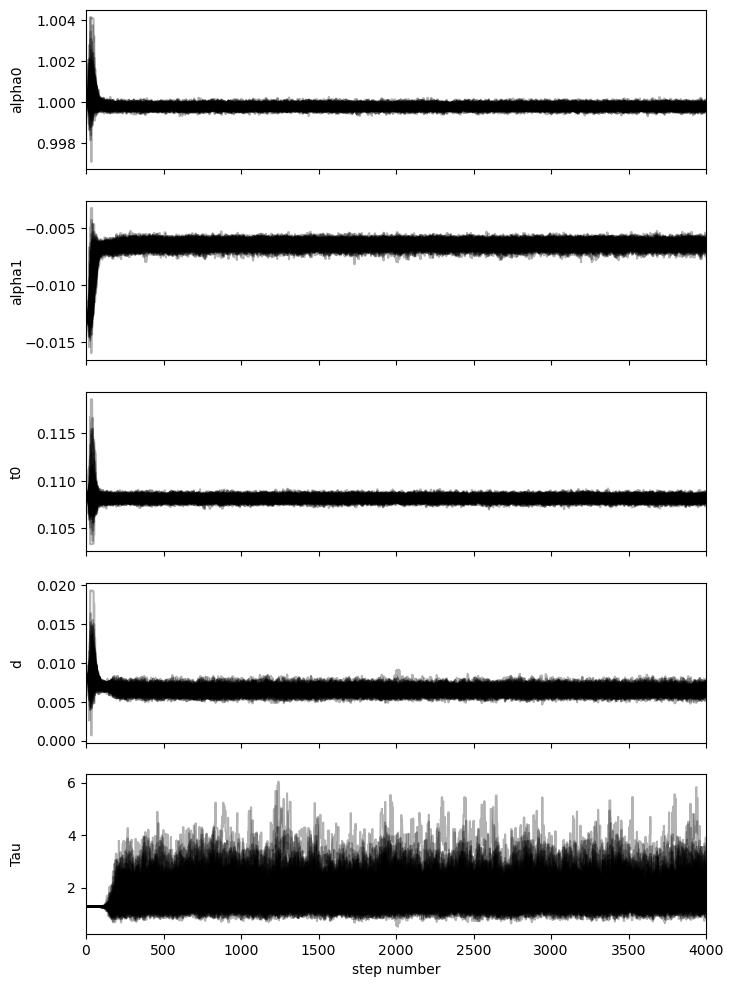

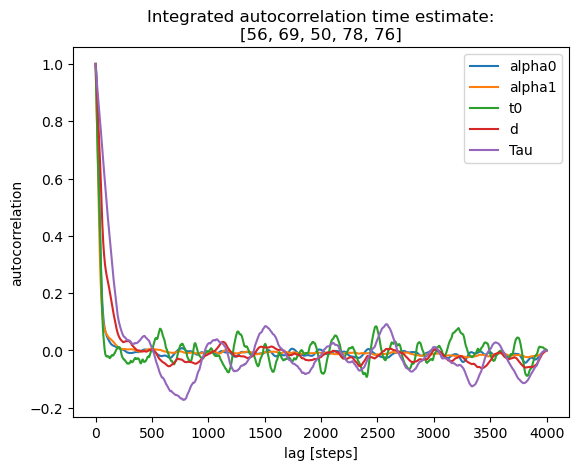

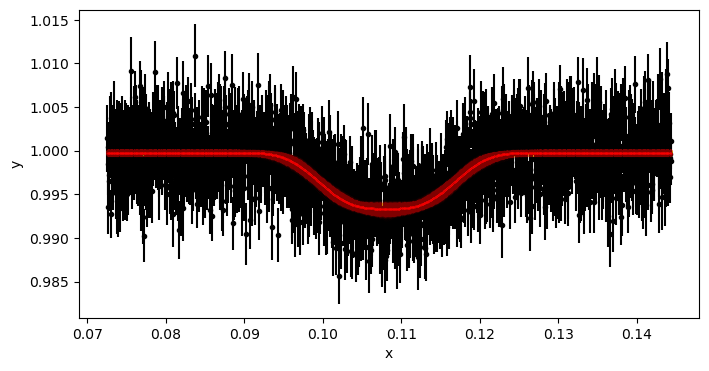

In [42]:
# run the initial model fit using MCMC for the primary  eclipses
# Do 2 different models: to account for depth variations
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()

    # nruns, discard = 20, 1
    nruns, discard = 4000, 600
    _data_primary = data_primary[(1980 <= data_primary.time) & (data_primary.time < 2050)]  # sectors 25, 26: deeper dips
    mean_alpha0_a, mean_alpha1_a, mean_t0_a, mean_d_a, mean_Tau_a, fit_params_stats_a = etv_functions.run_mcmc_initial_fit(_data_primary, start_vals, nruns=nruns, discard=discard, autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)

    _data_primary = data_primary[(2700 <= data_primary.time) & (data_primary.time < 2800)]  # sectors 52, 53: shallower deeper dips
    mean_alpha0_b, mean_alpha1_b, mean_t0_b, mean_d_b, mean_Tau_b, fit_params_stats_b = etv_functions.run_mcmc_initial_fit(_data_primary, start_vals, nruns=nruns, discard=discard, autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)
    
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
# if not run_init_fit:  # case init fit has been previously saved and to be reussed
if True: 
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data (wide window for clipped LC)
    mean_alpha0_a, mean_alpha1_a, mean_t0_a, mean_d_a, mean_Tau_a = 1.0003723767133315, -0.019648606991144922, 0.1082588727363964, 0.00865023109594781, 1.255161754593292
    mean_alpha0_b, mean_alpha1_b, mean_t0_b, mean_d_b, mean_Tau_b = 0.9997864279978209, -0.0064251797444982795, 0.10813441069914584, 0.006457807603857748, 1.6800961079641747

    # mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 
    

    # should split data_primary for clearer display
    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0_a, mean_alpha1_a, mean_t0_a, mean_d_a, mean_Tau_a])
    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0_b, mean_alpha1_b, mean_t0_b, mean_d_b, mean_Tau_b])
    
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])

In [43]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

# print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
print("mean_alpha0_a, mean_alpha1_a, mean_t0_a, mean_d_a, mean_Tau_a = " + "_a, ".join([str(v) for v in [mean_alpha0_a, mean_alpha1_a, mean_t0_a, mean_d_a, mean_Tau_a]]))
print("mean_alpha0_b, mean_alpha1_b, mean_t0_b, mean_d_b, mean_Tau_b = " + "_b, ".join([str(v) for v in [mean_alpha0_b, mean_alpha1_b, mean_t0_b, mean_d_b, mean_Tau_b]]))

Initial model params:
mean_alpha0_a, mean_alpha1_a, mean_t0_a, mean_d_a, mean_Tau_a = 1.0003723767133315_a, -0.019648606991144922_a, 0.1082588727363964_a, 0.00865023109594781_a, 1.255161754593292
mean_alpha0_b, mean_alpha1_b, mean_t0_b, mean_d_b, mean_Tau_b = 0.9997864279978209_b, -0.0064251797444982795_b, 0.10813441069914584_b, 0.006457807603857748_b, 1.6800961079641747


### Run custom indiviual fit (per-sector)

- the eclipse depth varies greatly over time. The standard codes `fit_each_eclipse()` would not work well, as they assume consistent eclipse shape (`d` and `Tau`), but the varying depth means the shape varies over time too.

#### per-sector fit for `data_primary`

100%|██████████████████████████████████████████████████████████| 5000/5000 [00:51<00:00, 96.28it/s]


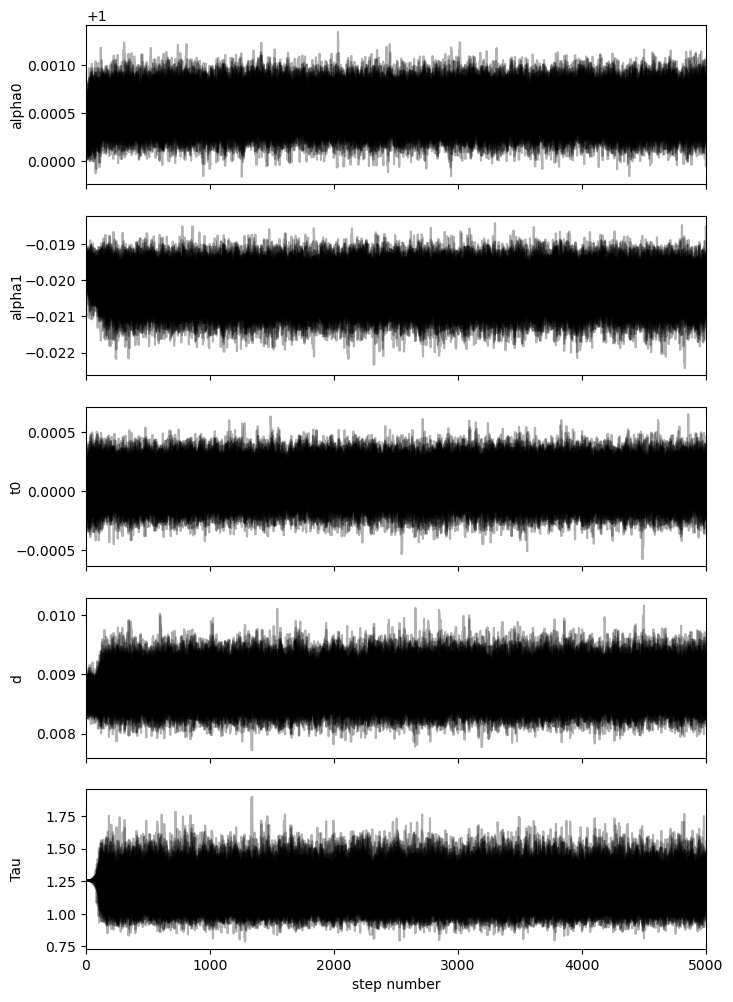

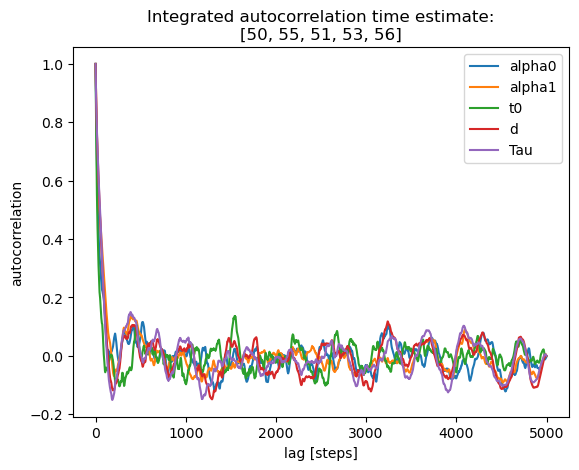

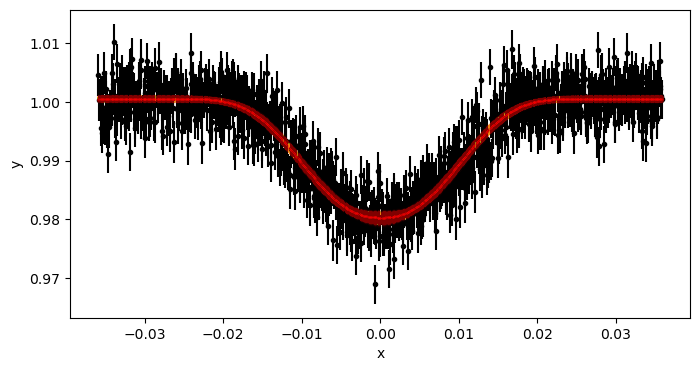

25 1998.0740632176287


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:56<00:00, 88.75it/s]


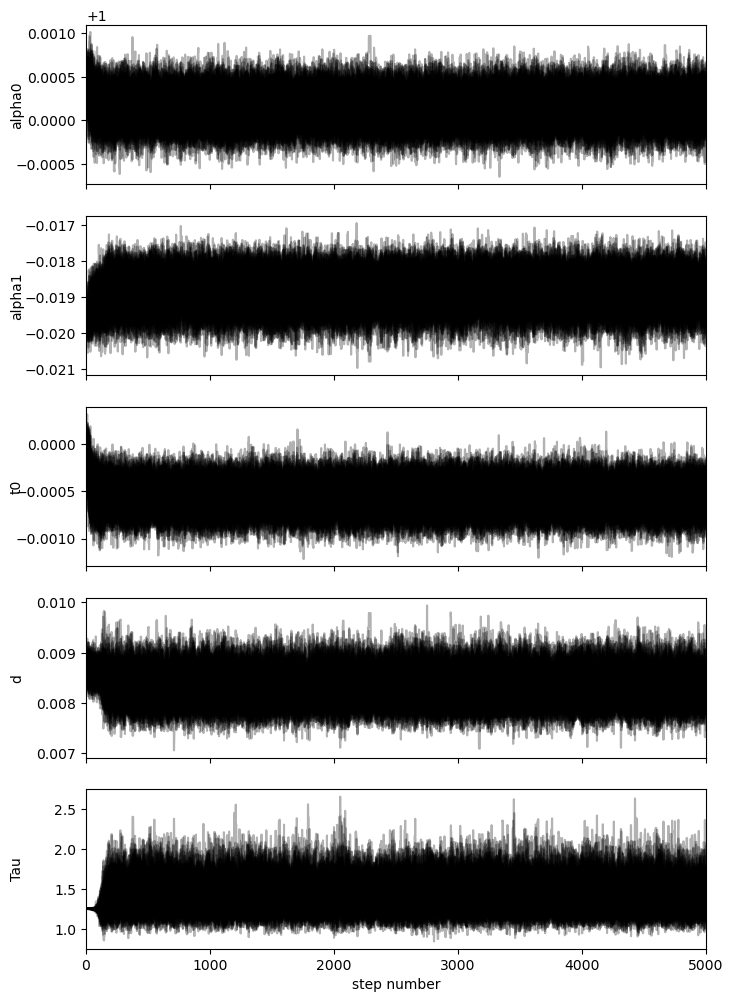

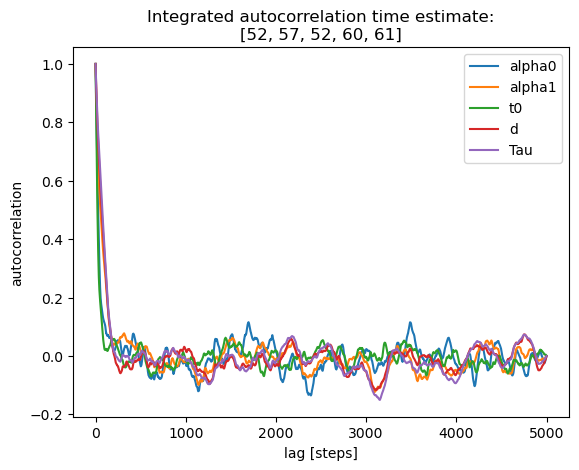

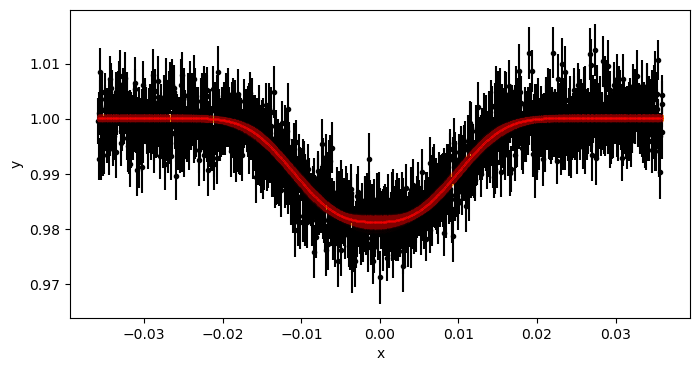

26 2023.0350287763133


100%|█████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 130.44it/s]


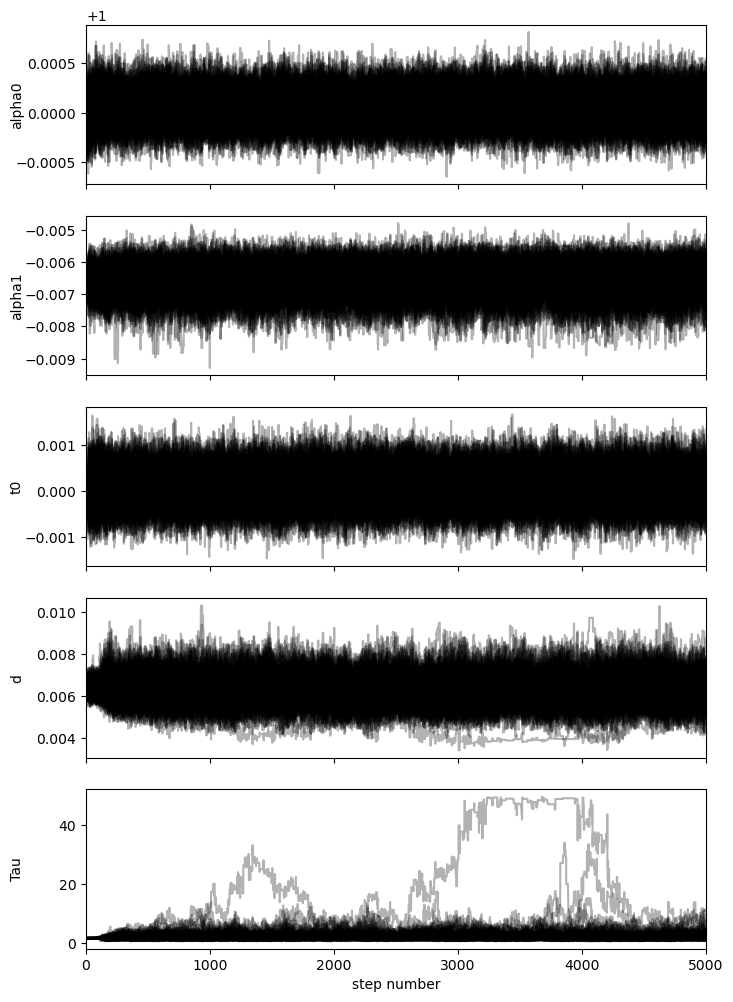

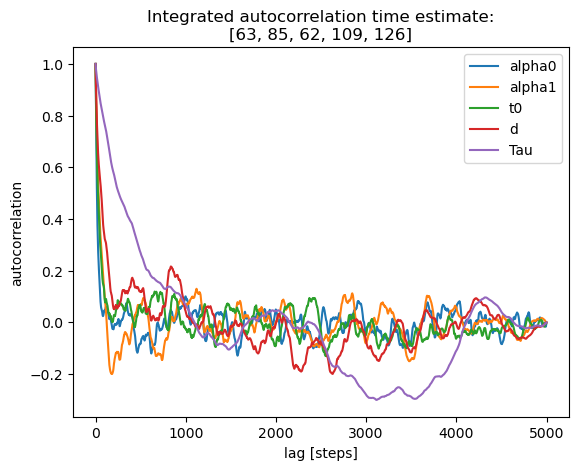

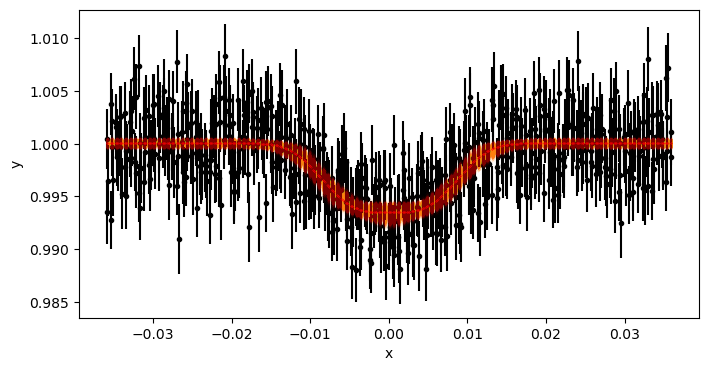

52 2731.03104643744


100%|█████████████████████████████████████████████████████████| 5000/5000 [00:47<00:00, 105.35it/s]


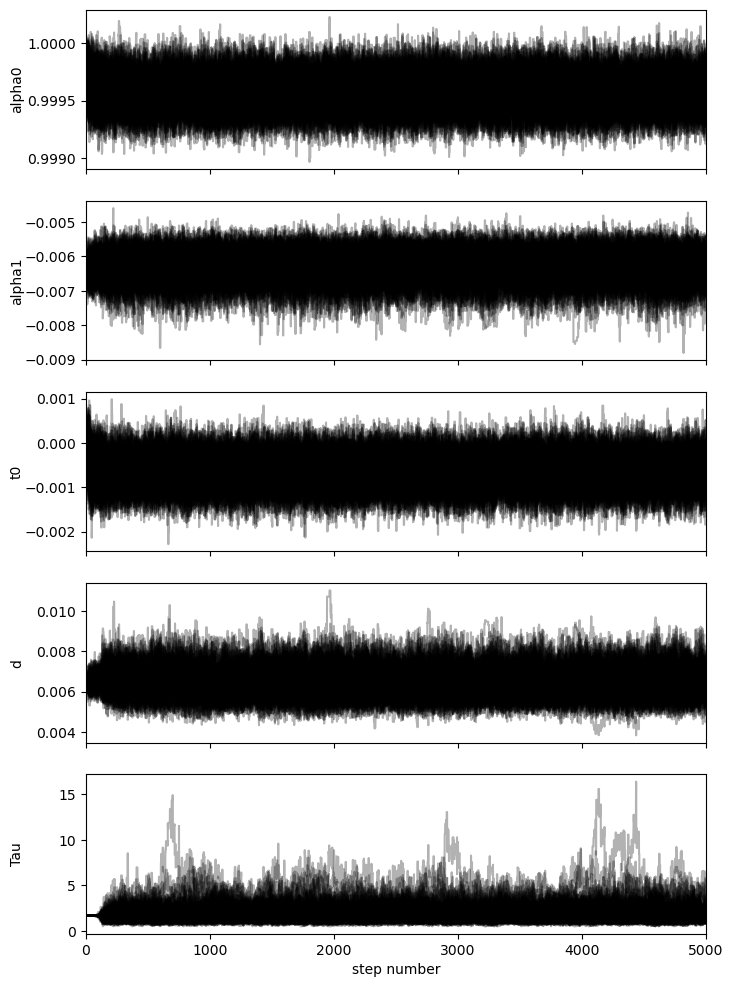

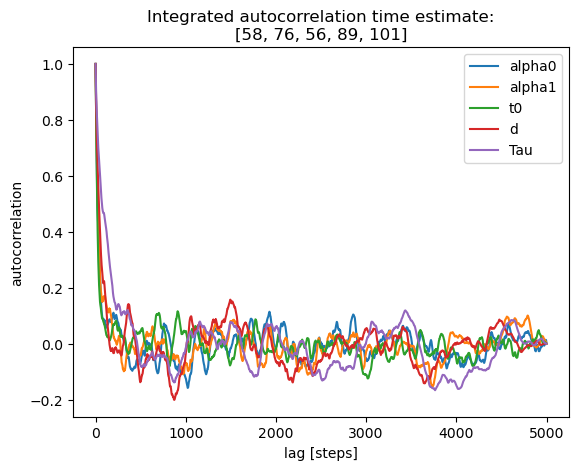

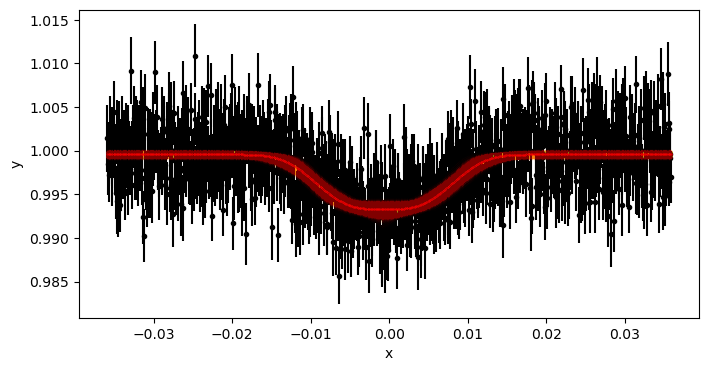

53 2756.102653192084
number,epoch,mean_alpha0,mean_alpha1,t0,stdv_t0,mean_d,mean_Tau
25,1998.0740632176287,1.0005417672113763,-0.020229659270303867,6.753677723570346e-05,0.0001258251242033807,0.008811151227473977,1.1809617423849232
26,2023.0350287763133,1.000143101829554,-0.018832106120386494,-0.00055440122877044,0.00015267894587752982,0.008324573997905578,1.4190158966671012
52,2731.03104643744,1.0000541552477582,-0.006571416658539879,9.882673912635834e-05,0.0003700899438121841,0.006273137919880838,1.814697435919489
53,2756.102653192084,0.9995758043418744,-0.006274237374779083,-0.000644491466138875,0.00034380659459612087,0.006448952813922533,1.719855704584358



In [30]:
from types import SimpleNamespace

# reload(emcee.ensemble)
# reload(emcee)

etv_out_str = "number,epoch,mean_alpha0,mean_alpha1,t0,stdv_t0,mean_d,mean_Tau\n"

# # _alpha1_limit = -10  # the default in original log_prior
# _alpha1_limit = mean_alpha1_a * 5

# def custom_log_prior(theta):
#     # print("DBG log_prior() _alpha1_limit", _alpha1_limit)
#     alpha0, alpha1, t0, d, Tau = theta
#     if (0 < alpha0 < 10) and (_alpha1_limit < alpha1 < 0) and (-0.5 < t0 < 0.5) and (0 < d < 10) and (0.5 < Tau < 50):
#         return 0.0
#     # raise ValueError(f"log_prior(): theta outside acceptable range: {theta}")  # for debug
#     return -np.inf

# def custom_log_probability(theta, x, y, yerr):
#     # check that the priors are satisfied
#     lp = custom_log_prior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + etv_functions.log_likelihood(theta, x, y, yerr)


for lc in lcc_tess[:]: 
    lc_f = lc.remove_nans().normalize().fold(epoch_time=t0_primary, period=period, normalize_phase=True)
    lc_f = lc_f.truncate(-window_width_p / 2, window_width_p / 2)
    # if True:
    #     ax = lc_f.scatter(label=f"S. {lc.sector}");  # for diagnostics
    #     continue
    
    # convert lc to the form needed by fit etv_functions
    lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))

    if 25 <= lc_f.sector <= 26:
        start_vals_dict = dict(alpha0=mean_alpha0_a, alpha1=mean_alpha1_a, t0=0, d=mean_d_a, Tau=mean_Tau_a)
    elif 52 <= lc_f.sector <= 53:
        start_vals_dict = dict(alpha0=mean_alpha0_b, alpha1=mean_alpha1_b, t0=0, d=mean_d_b, Tau=mean_Tau_b)
    else:
        raise Exception("We have start_vals for sectors 25, 26, 52, 53 only")

    # _alpha1_limit = start_vals_dict["alpha1"] * 5
    
    # if True:
    #     print("DBG", custom_log_prior(start_vals_dict.values()))
    #     continue


    _alpha0, _alpha1, _t0, _d, _Tau, _fit_params_stats = etv_functions.run_mcmc_initial_fit_of_model(
        etv_functions.log_probability, etv_functions.coshgauss_model_fit,  # no need of custom_prior after all, defaults are fine
        # custom_log_probability, etv_functions.coshgauss_model_fit,
        lc_f_data, start_vals_dict, 
        # nruns=20, discard=1, 
        nruns=5000, discard=1000,
        autocorr_time_kwargs=dict(tol=20), pool=None, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)
    
    _stdv_t0 = _fit_params_stats["std_t0"]
    _t = np.mean(lc_f.time_original.value)  # approximate transit time 
    print(lc.sector, _t)
    
    etv_out_str += ",".join([str(s) for s in [lc.sector, _t, _alpha0, _alpha1, _t0, _stdv_t0, _d, _Tau]])
    etv_out_str += "\n"

print(etv_out_str)

In [ ]:
# # Keep the result in a cell for safekeeping
# etv_out_str = """\
# number,epoch,mean_alpha0,mean_alpha1,t0,stdv_t0,mean_d,mean_Tau
# 25,1998.0740632176287,1.0005417672113763,-0.020229659270303867,6.753677723570346e-05,0.0001258251242033807,0.008811151227473977,1.1809617423849232
# 26,2023.0350287763133,1.000143101829554,-0.018832106120386494,-0.00055440122877044,0.00015267894587752982,0.008324573997905578,1.4190158966671012
# 52,2731.03104643744,1.0000541552477582,-0.006571416658539879,9.882673912635834e-05,0.0003700899438121841,0.006273137919880838,1.814697435919489
# 53,2756.102653192084,0.9995758043418744,-0.006274237374779083,-0.000644491466138875,0.00034380659459612087,0.006448952813922533,1.719855704584358
# """

### Run custom individual fit (per-cycle)

In [35]:
# the stitched, outlier-filtered  data
lc_data = lk.LightCurve(time=Time(data.time, format="btjd"), flux=data.flux, flux_err=data.err)
len(lc_data)
# lc_data.scatter();

53495

#### per-cycle fit for `data_primary`

100%|██████████████████████████████████████████████████████████| 5000/5000 [00:52<00:00, 95.99it/s]
The chain is shorter than 20 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/20 = 250;
tau: [370.78611628 568.33522279 376.9771136  336.79552568 500.86181818]


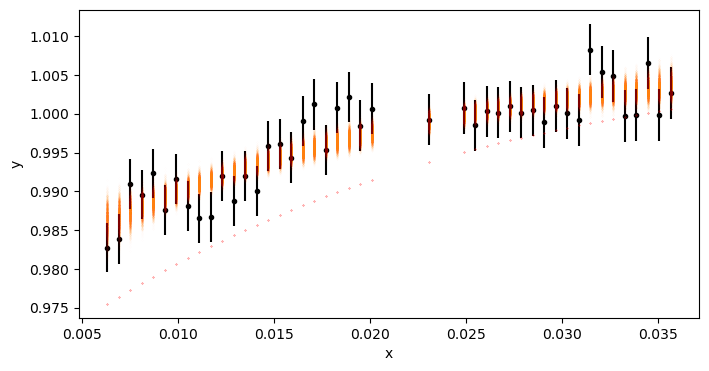

0 1983.677488492449


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:51<00:00, 96.33it/s]


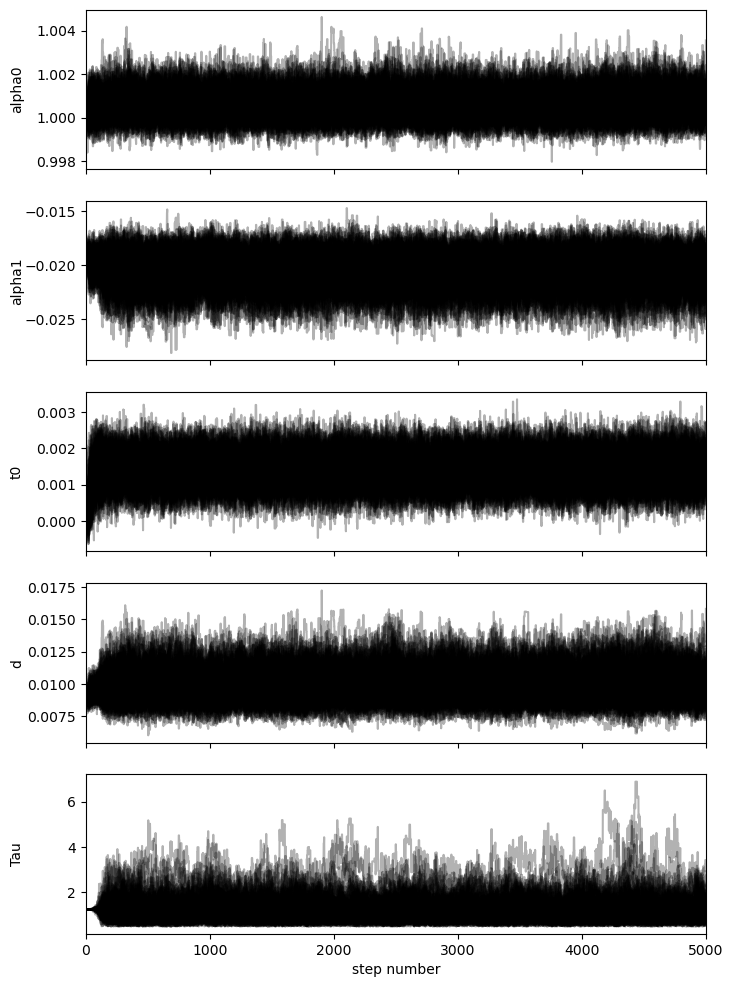

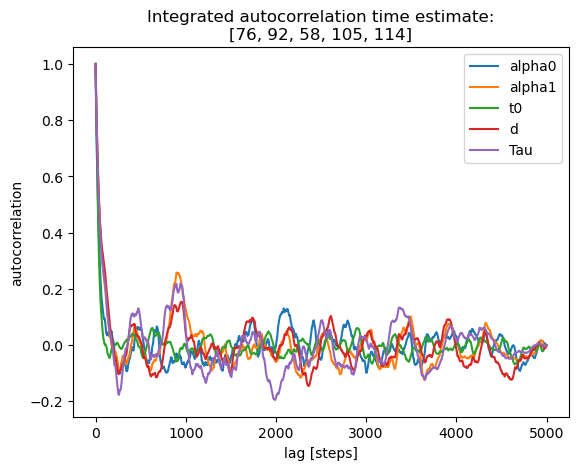

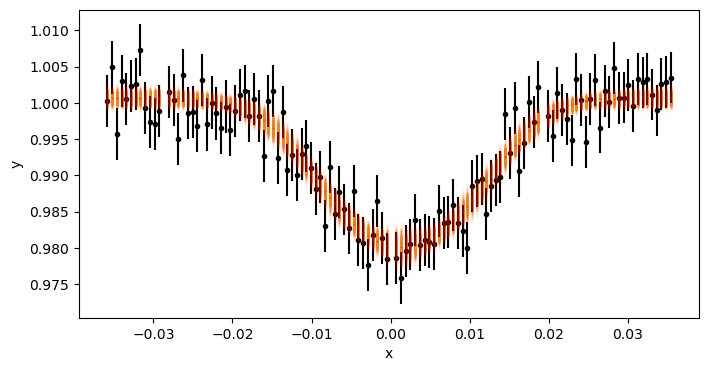

2 1988.2684656227339


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:53<00:00, 93.10it/s]


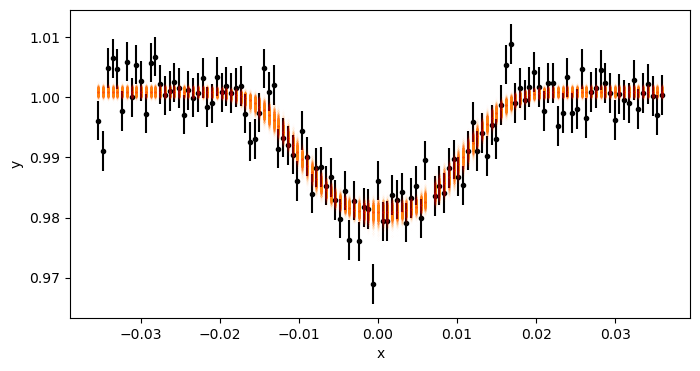

3 1990.5890469260512


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:53<00:00, 93.93it/s]


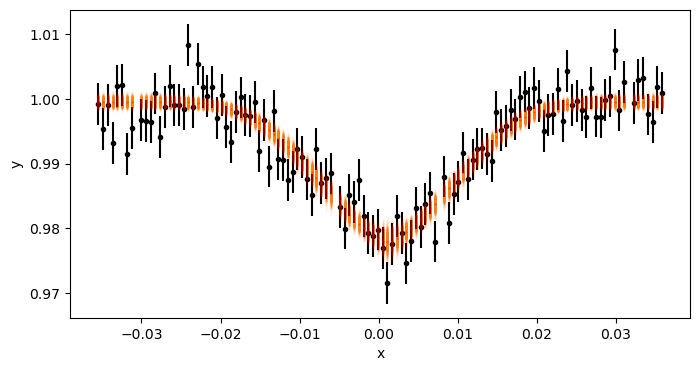

4 1992.9086075266118


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:53<00:00, 94.14it/s]


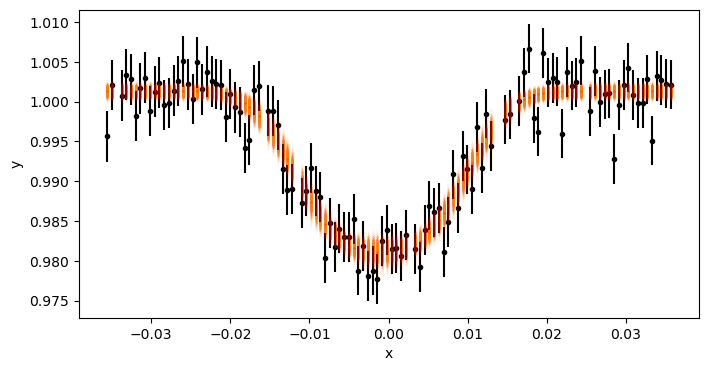

5 1995.2279549505927


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:54<00:00, 92.04it/s]


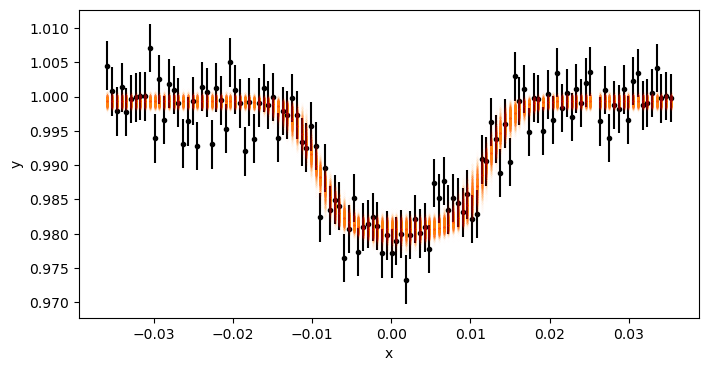

8 2002.1860290910724


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:53<00:00, 94.18it/s]


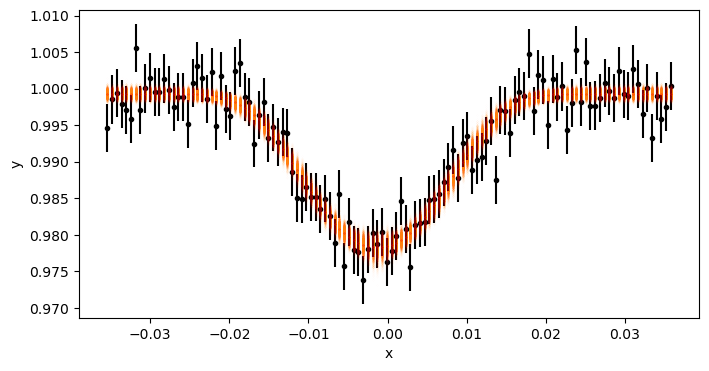

9 2004.5073870967258


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:52<00:00, 95.07it/s]


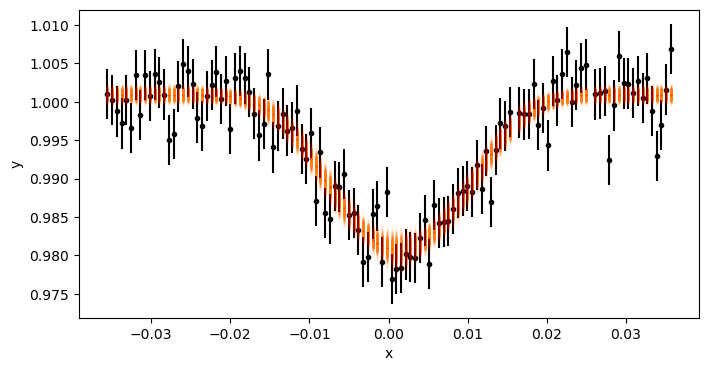

10 2006.8260350570927


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:52<00:00, 94.95it/s]


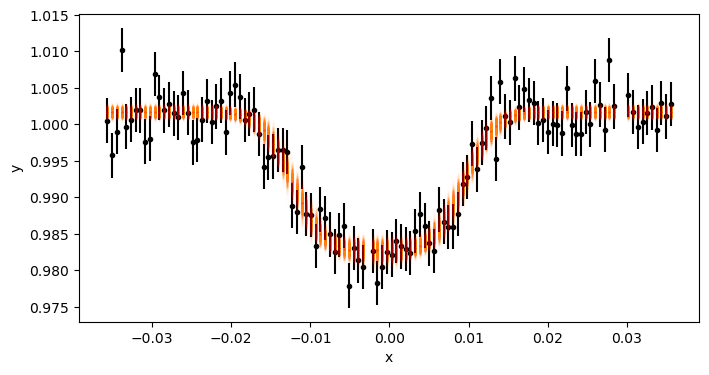

11 2009.1451969764864


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:51<00:00, 97.35it/s]


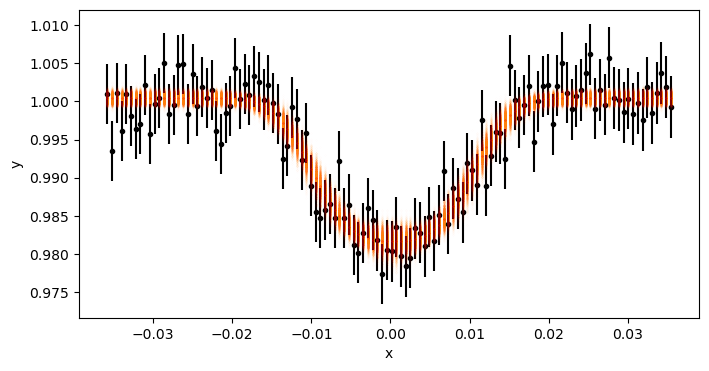

12 2011.4657453169855


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:52<00:00, 95.83it/s]


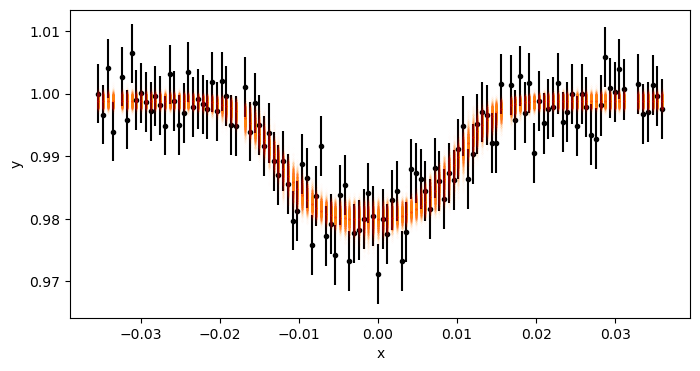

13 2013.7859982427385


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:53<00:00, 93.86it/s]


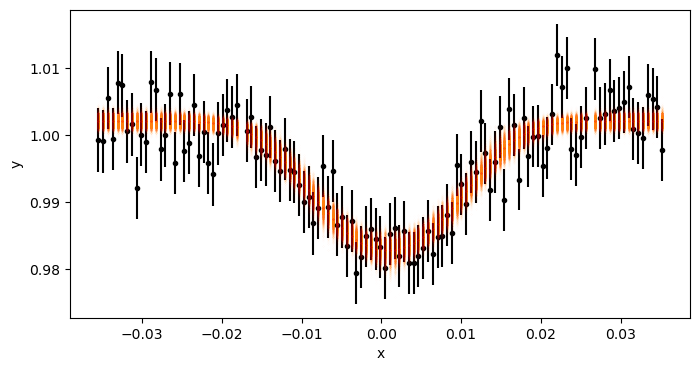

14 2016.1051363780423


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:52<00:00, 95.46it/s]


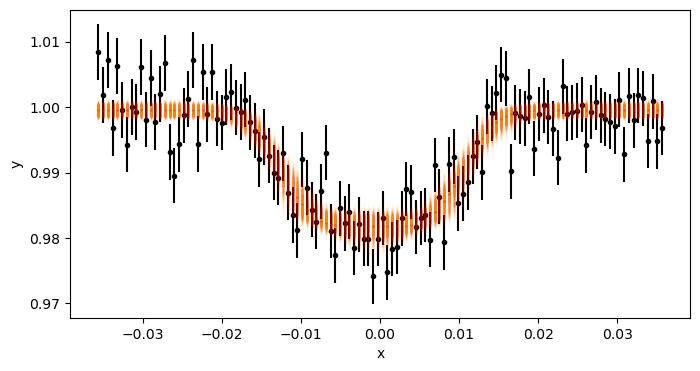

15 2018.4254444193405


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:51<00:00, 97.20it/s]


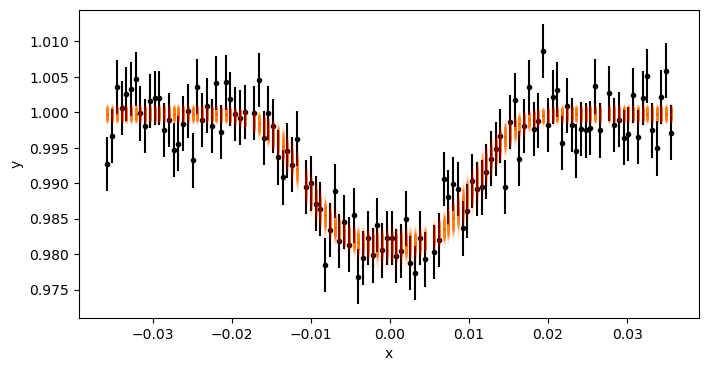

16 2020.744807093657


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:51<00:00, 97.71it/s]
The chain is shorter than 20 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/20 = 250;
tau: [167.78589456 213.87984121 389.42838127 206.83113799 229.63056449]
C:\dev\_juypter\PH_TESS_LightCurveViewer\eb_with_diff_sb_period\etv\etv_functions.py:290: RuntimeWarning: overflow encountered in cosh
  cosh_term = np.cosh((x - t0) / d)


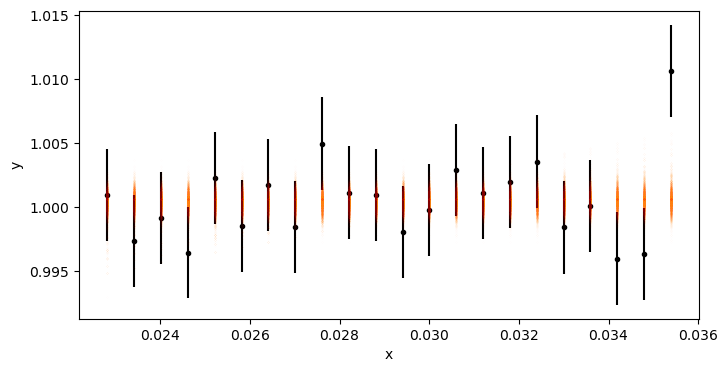

17 2023.1323605709995


100%|██████████████████████████████████████████████████████████| 5000/5000 [01:02<00:00, 79.84it/s]


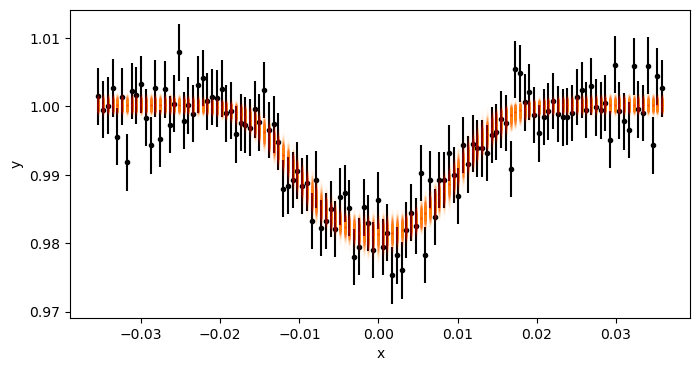

18 2025.3851063348222


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:55<00:00, 90.19it/s]


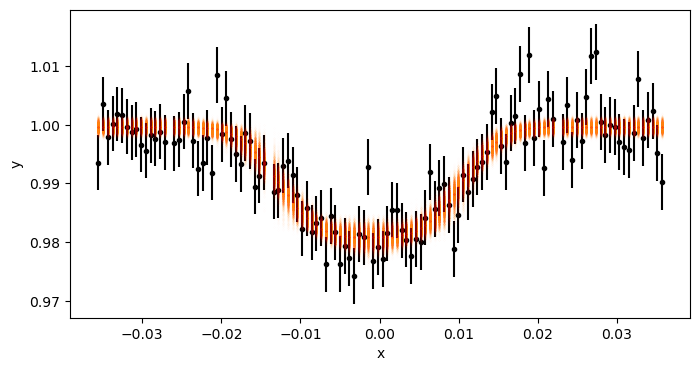

19 2027.704880825196


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:53<00:00, 93.50it/s]
The chain is shorter than 20 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/20 = 250;
tau: [104.93548802 163.59040554  80.03184112 271.34649196 206.39338921]


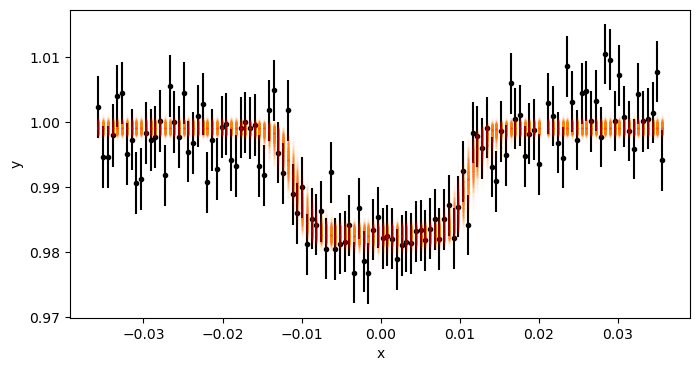

20 2030.0235275451191


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:53<00:00, 93.31it/s]


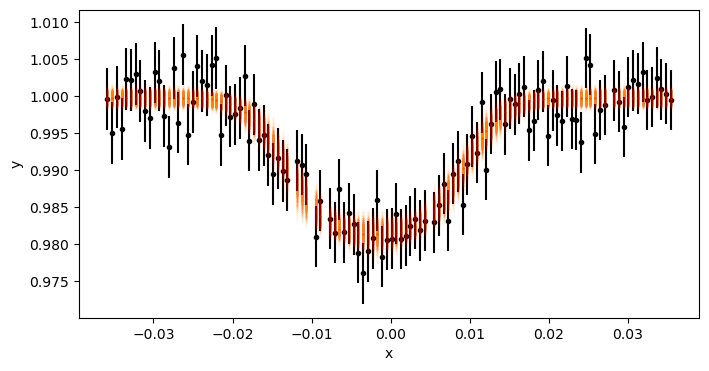

21 2032.3432860822547


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:56<00:00, 88.09it/s]


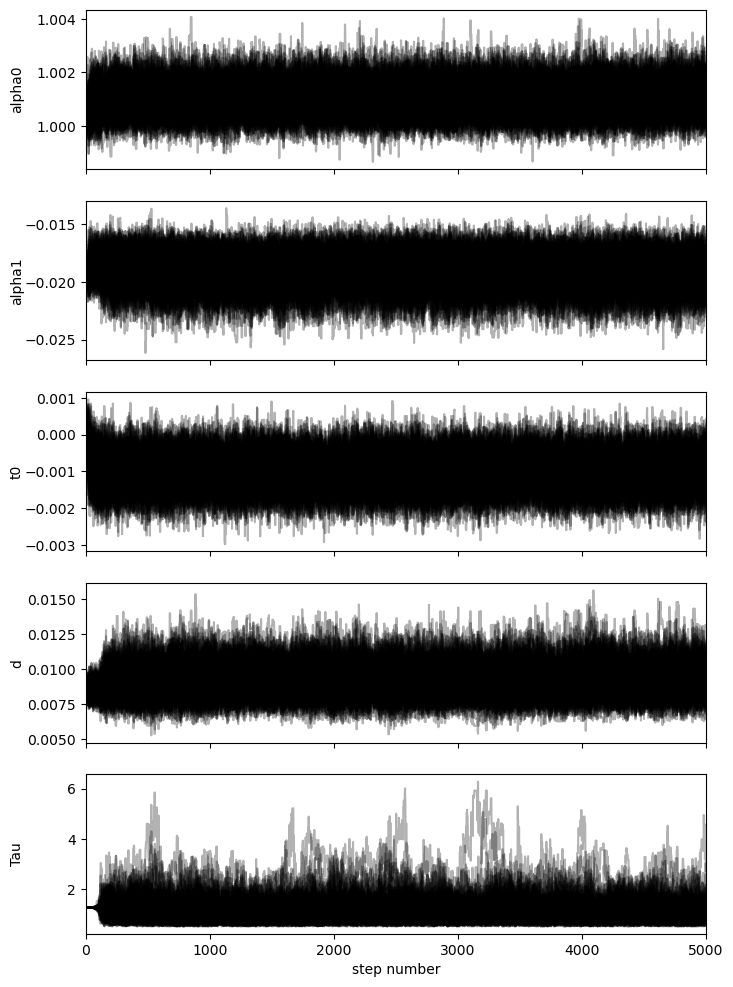

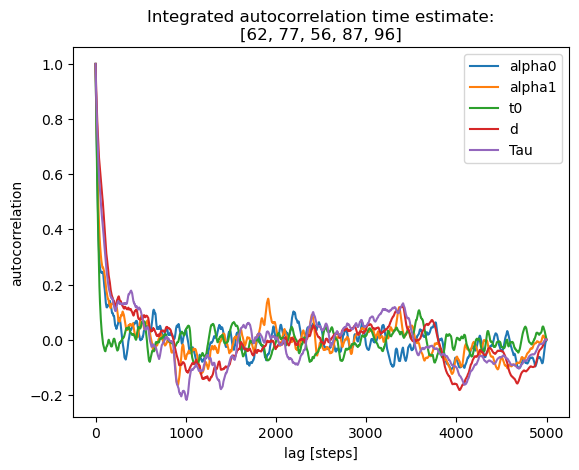

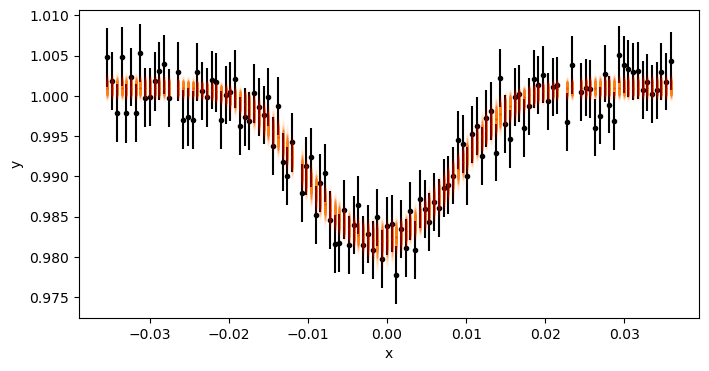

22 2034.6640075281132


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:58<00:00, 86.17it/s]


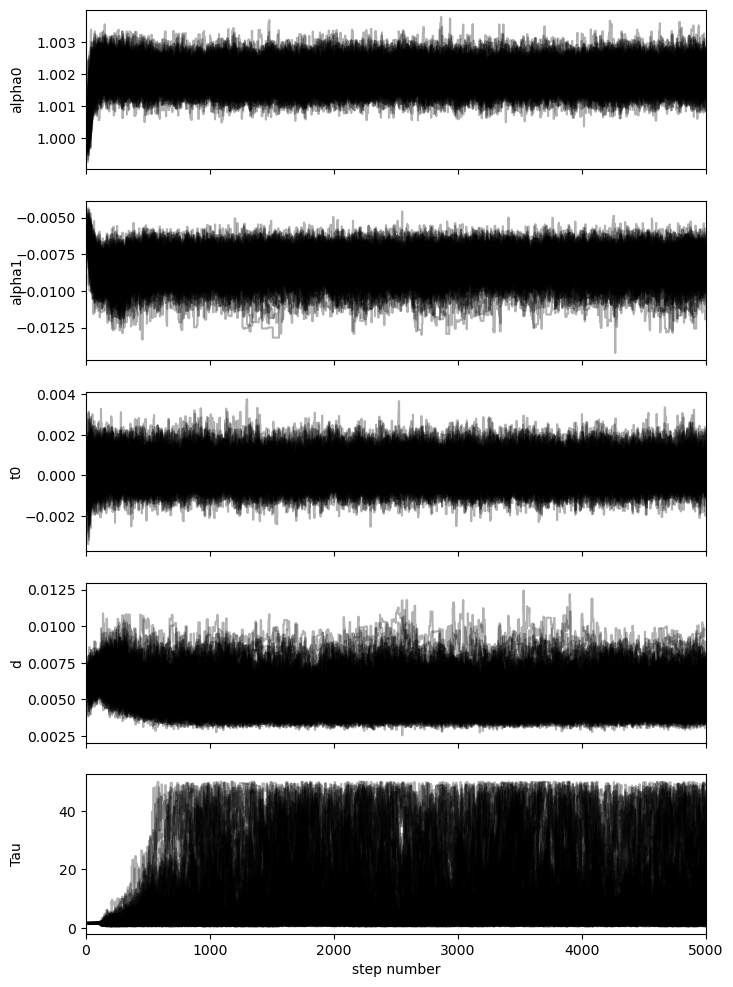

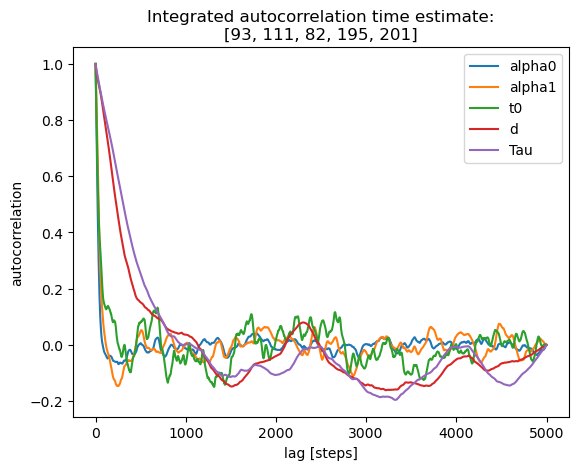

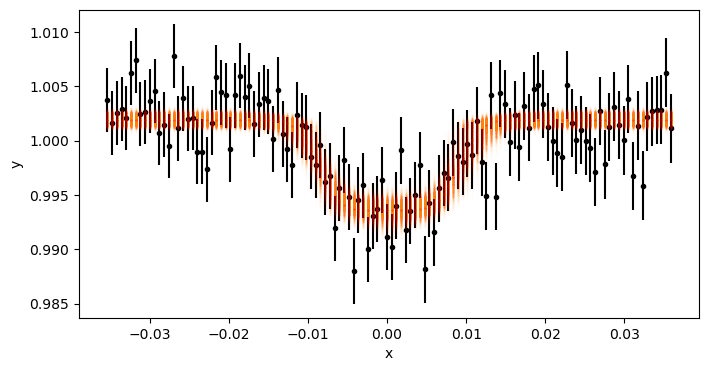

317 2718.98744353184


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:56<00:00, 87.83it/s]


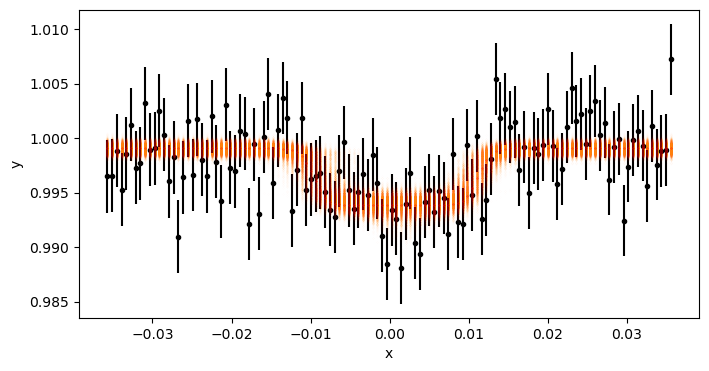

320 2725.945879262748


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:58<00:00, 86.15it/s]


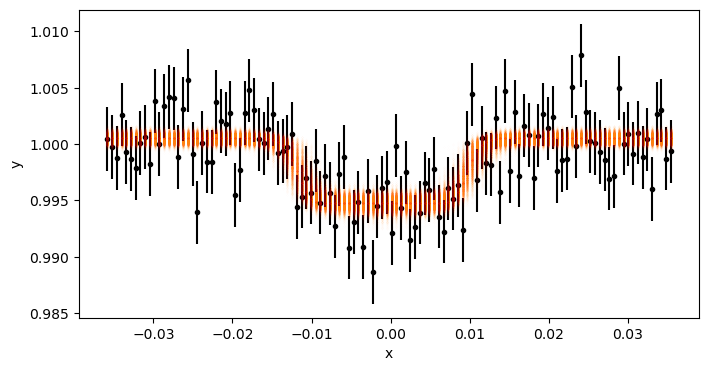

321 2728.265357629559


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:55<00:00, 89.77it/s]


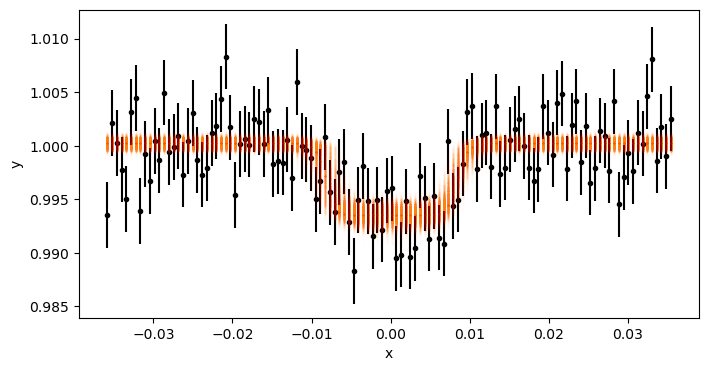

326 2739.8640427495675


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:57<00:00, 87.14it/s]


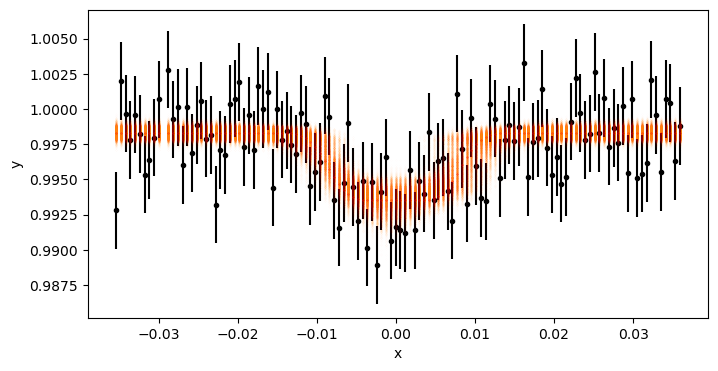

327 2742.1854624805123


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:57<00:00, 86.98it/s]


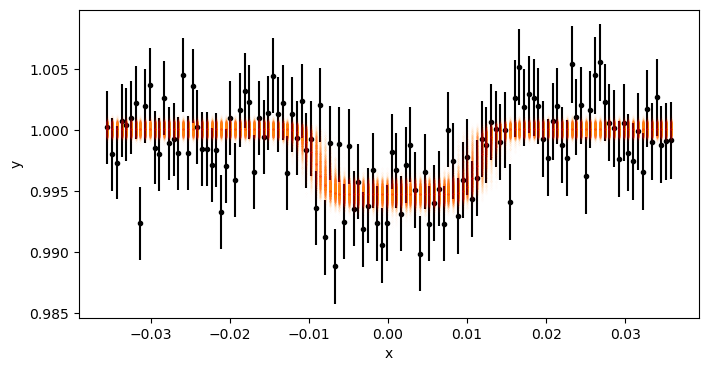

328 2744.504328250563


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:58<00:00, 85.97it/s]


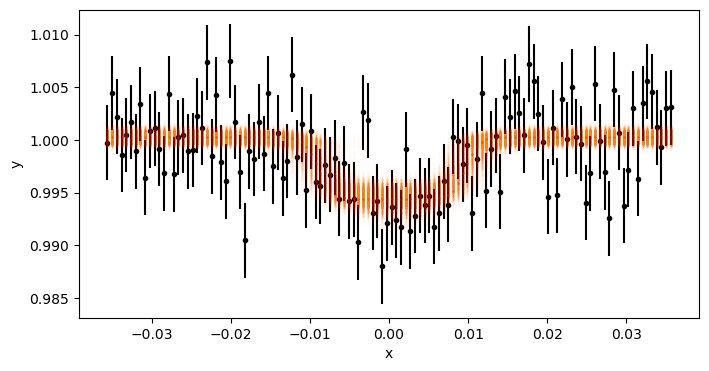

329 2746.8237563157336


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:56<00:00, 88.73it/s]
The chain is shorter than 20 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/20 = 250;
tau: [210.55118509 208.69299155 156.82468515 317.14770056 233.38923887]


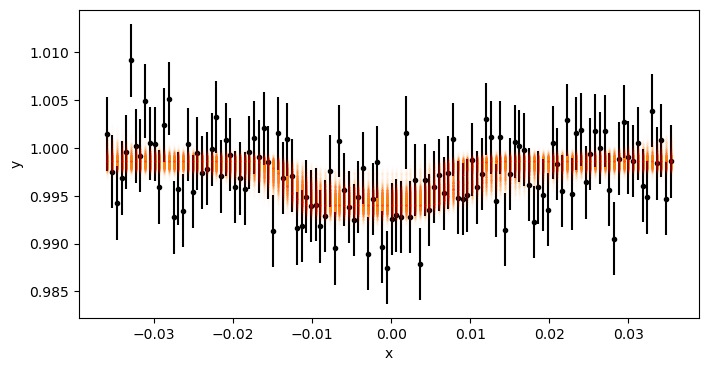

331 2751.462616197616


100%|██████████████████████████████████████████████████████████| 5000/5000 [01:01<00:00, 81.59it/s]


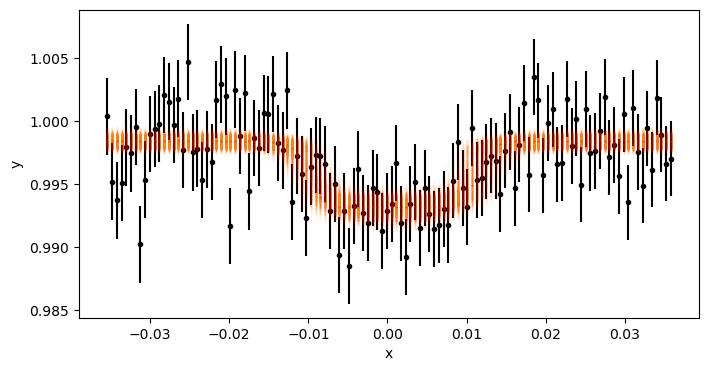

332 2753.7834338810176


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:53<00:00, 93.49it/s]
The chain is shorter than 20 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/20 = 250;
tau: [112.72949253 112.78181167 123.69060146 278.76258619 226.55549442]


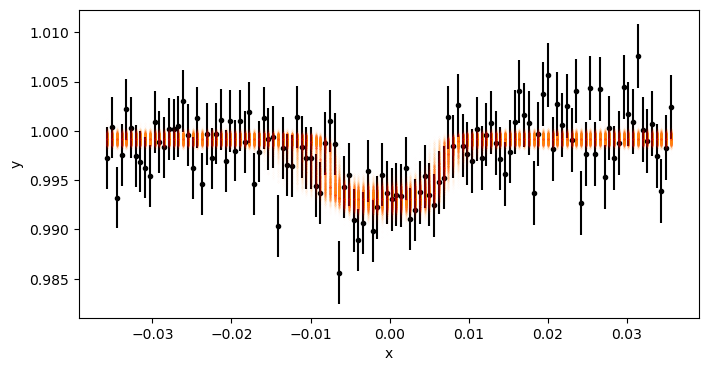

334 2758.42226863556


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:53<00:00, 93.67it/s]


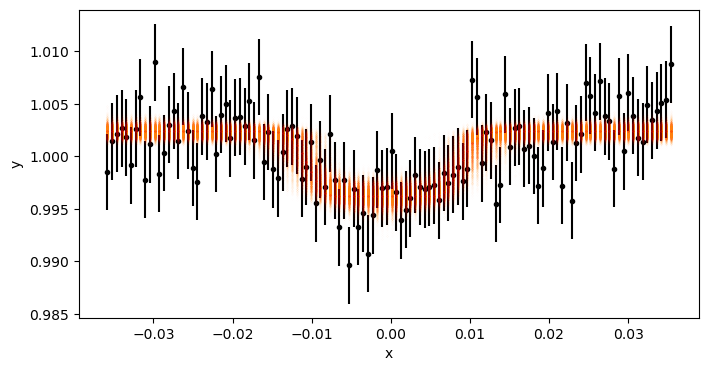

335 2760.741673121443


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:53<00:00, 93.79it/s]


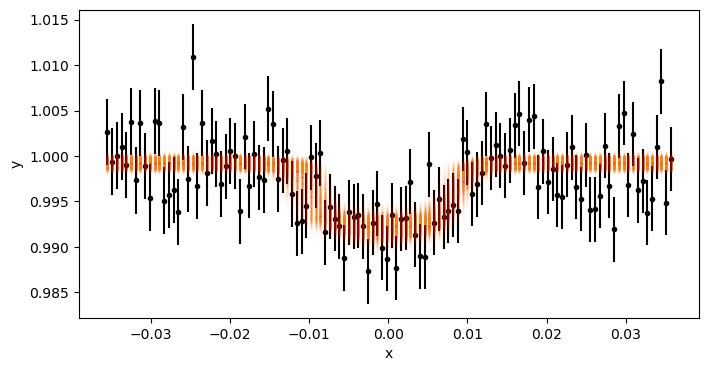

337 2765.3818724183193


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:53<00:00, 92.78it/s]


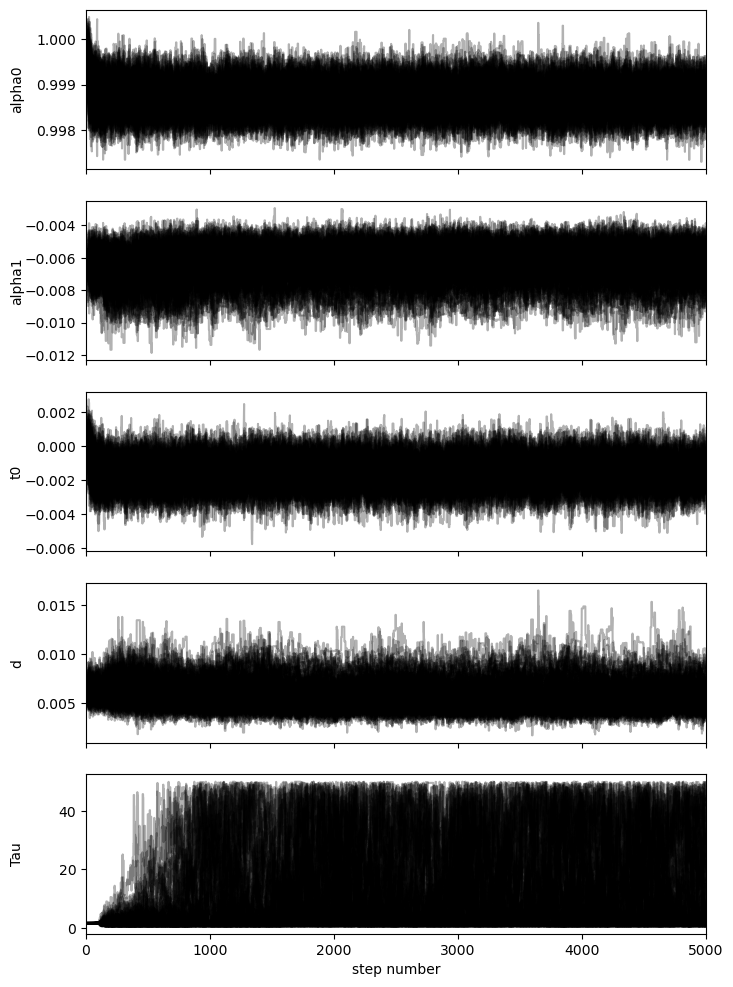

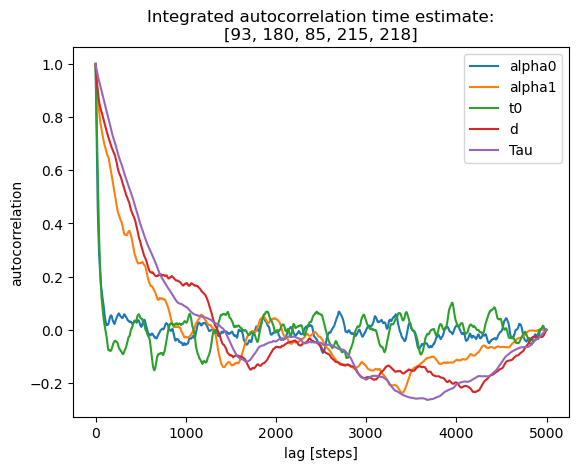

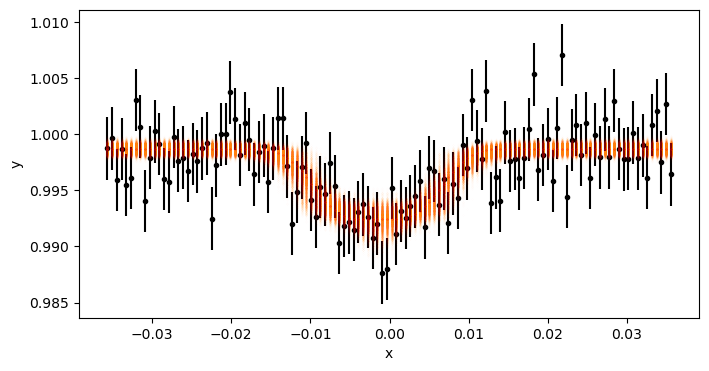

338 2767.7012767164133
number,epoch,mean_alpha0,mean_alpha1,t0,stdv_t0,mean_d,mean_Tau
0,1983.677488492449,1.0067173840955563,-0.7698666395987233,-0.33865517512443766,0.10482951101156993,0.13305312849725365,12.599738323203319
2,1988.2684656227339,1.0006140229362432,-0.020441559261812556,0.001433329401607313,0.000424662366222931,0.009908311123082355,1.0878742517872046
3,1990.5890469260512,1.0009162657588506,-0.020062159783977483,0.000500922733920651,0.0003549873839609106,0.007996252481905016,1.572219027506169
4,1992.9086075266118,0.9995515382221491,-0.021639647185874092,0.0010562417469696195,0.0003667764842974795,0.010001236876603658,0.7381865618747678
5,1995.2279549505927,1.0013044963148892,-0.020148174141095255,-0.0009913713953427713,0.0003465846475202501,0.008329163811021095,1.5057420234162056
8,2002.1860290910724,0.9992923109252037,-0.01861678187153434,0.0011716941949541258,0.0003489595893794145,0.0065188336652693656,3.4156312877075132
9,2004.5073870967258,0.9993241419860381,-0.0209

In [46]:

_lc_data_f = lc_data.fold(epoch_time=t0_primary, period=period, normalize_phase=True)

c_etv_out_str = "number,epoch,mean_alpha0,mean_alpha1,t0,stdv_t0,mean_d,mean_Tau\n"

for c in np.unique(_lc_data_f.cycle):
    lc_f = _lc_data_f[_lc_data_f.cycle == c]
    lc_f = lc_f.truncate(-window_width_p / 2, window_width_p / 2)
    if len(lc_f) < 1:
        continue

    if len(lc_f) < 8:
        print(f"Skipped cycle {c} due to insuffient data points {len(lc_f)}")
        continue

    verbose_cycles = [2, 22, 317, 338]  # selected cycles of sectors 25, 26, 52, 53

    # if c not in verbose_cycles:  # for trying a few cycles
    #     continue

    # if True:
    #     ax = lc_f.scatter(label=f"C.{c}");  # for diagnostics
    #     continue


    plot_chains, plot_autocorrelation = False, False
    if c in verbose_cycles:  # show MCMC details for selected cycles
        plot_chains, plot_autocorrelation = True, True  

    # convert lc to the form needed by fit etv_functions
    lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))

    
    if 1980 <= lc_f.time_original.value[0] <= 2050:  # sectors 25, 26
        start_vals_dict = dict(alpha0=mean_alpha0_a, alpha1=mean_alpha1_a, t0=0, d=mean_d_a, Tau=mean_Tau_a)
    elif 2700 <= lc_f.time_original.value[0] <= 2800:  # sectors 52, 53
        start_vals_dict = dict(alpha0=mean_alpha0_b, alpha1=mean_alpha1_b, t0=0, d=mean_d_b, Tau=mean_Tau_b)
    else:
        raise Exception("We have start_vals for sectors 25, 26, 52, 53 only")


    _alpha0, _alpha1, _t0, _d, _Tau, _fit_params_stats = etv_functions.run_mcmc_initial_fit_of_model(
        etv_functions.log_probability, etv_functions.coshgauss_model_fit,  # no need of custom_prior after all, defaults are fine
        lc_f_data, start_vals_dict, 
        # nruns=20, discard=1, 
        nruns=5000, discard=1000, 
        autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=plot_chains,  plot_autocorrelation=plot_autocorrelation, plot=True, also_return_stats=True)
    _stdv_t0 = _fit_params_stats["std_t0"]
    _t = np.mean(lc_f.time_original.value)  # approximate transit time 
    print(c, _t)
    
    c_etv_out_str += ",".join([str(s) for s in [c, _t, _alpha0, _alpha1, _t0, _stdv_t0, _d, _Tau]])
    c_etv_out_str += "\n"
    
print(c_etv_out_str)

In [ ]:
# # save the result in a cell for safekeeping
# c_etv_out_str = """
# number,epoch,mean_alpha0,mean_alpha1,t0,stdv_t0,mean_d,mean_Tau
# 0,1983.677488492449,1.0067173840955563,-0.7698666395987233,-0.33865517512443766,0.10482951101156993,0.13305312849725365,12.599738323203319
# 2,1988.2684656227339,1.0006140229362432,-0.020441559261812556,0.001433329401607313,0.000424662366222931,0.009908311123082355,1.0878742517872046
# 3,1990.5890469260512,1.0009162657588506,-0.020062159783977483,0.000500922733920651,0.0003549873839609106,0.007996252481905016,1.572219027506169
# 4,1992.9086075266118,0.9995515382221491,-0.021639647185874092,0.0010562417469696195,0.0003667764842974795,0.010001236876603658,0.7381865618747678
# 5,1995.2279549505927,1.0013044963148892,-0.020148174141095255,-0.0009913713953427713,0.0003465846475202501,0.008329163811021095,1.5057420234162056
# 8,2002.1860290910724,0.9992923109252037,-0.01861678187153434,0.0011716941949541258,0.0003489595893794145,0.0065188336652693656,3.4156312877075132
# 9,2004.5073870967258,0.9993241419860381,-0.02099891486101,-0.0013393144479364129,0.00035270379898032965,0.00872550417230801,1.0881222701348343
# 10,2006.8260350570927,1.0009229948979121,-0.02024746126225007,0.0013647438374507217,0.0003697944432789197,0.008875135301325781,1.0140934162042485
# 11,2009.1451969764864,1.0016808609751386,-0.018926835876334765,-0.001481203677051604,0.0002980098147811806,0.007034033800636105,2.625598941992854
# 12,2011.4657453169855,1.000474330197659,-0.018744333473243294,0.0002764507229721945,0.00043416125942105746,0.0075872848455873325,1.653201565699421
# 13,2013.7859982427385,0.9988504672391654,-0.018841250741529487,-0.0013625409958986292,0.0005247311938166925,0.007959203652276467,1.9382094510826486
# 14,2016.1051363780423,1.0020614409174091,-0.019150600517736562,0.0007932084728200928,0.0005743965085110386,0.009056872572698445,1.0614013915760394
# 15,2018.4254444193405,0.9995375918888185,-0.017742568006136526,-0.00101528902668108,0.0004535534277158675,0.007410132901812205,2.754626404259238
# 16,2020.744807093657,0.9997784041239111,-0.018485259012213102,4.593606546810972e-05,0.0004309211450198397,0.007752202339249703,1.9219338211392245
# 17,2023.1323605709995,1.0006028981042894,-4.528827825054256,-0.1713171339581961,0.35078759402911885,0.050596950383568,23.015653217816258
# 18,2025.3851063348222,1.0002268392976124,-0.018918538806997266,-0.0002818172936894901,0.0004864496526171497,0.008387234850513651,1.3124846739331486
# 19,2027.704880825196,0.9996308380959411,-0.018765407429876074,-0.0011887068673599732,0.0005725429188354993,0.008097459826283843,1.9769459221849106
# 20,2030.0235275451191,0.9991413727667298,-0.01656549030782771,-7.636552555987708e-06,0.00039606205075664317,0.005204741904405647,15.97543191259707
# 21,2032.3432860822547,0.9997774810124282,-0.018339456738322584,-0.0020094688844935447,0.0005010473581131513,0.008151126273664953,1.7609742814971268
# 22,2034.6640075281132,1.0010404060062197,-0.01902456300004783,-0.0009989629405777456,0.0004442045262302452,0.009139035118989893,1.0337599373956143
# 317,2718.98744353184,1.001926908201944,-0.008310128480798804,0.000183013955041213,0.0006605975900844992,0.005344589844807563,3.6583336379154403
# 320,2725.945879262748,0.9990606357324672,-0.005166526665932108,0.0007335492532763767,0.0011438307602286992,0.004892896779913249,16.941559496286388
# 321,2728.265357629559,1.0005132266520913,-0.0057488656912131056,-0.0010921960967027933,0.000711216864509557,0.005015415645995114,19.920233804567893
# 326,2739.8640427495675,1.0002263081157432,-0.00668161876950223,0.00011894323296138214,0.0006652983582564351,0.0038922269500419183,17.42377317030443
# 327,2742.1854624805123,0.9983133372538613,-0.004800089280452017,-0.00015211616323199654,0.0012534481633802055,0.004943734688543691,4.017456862064517
# 328,2744.504328250563,1.00008009223647,-0.0053049934931645,0.0011068821103292173,0.0007811342048547692,0.004751924536274611,22.26294824254428
# 329,2746.8237563157336,1.0002904623042177,-0.005869372451899828,0.0003137969513598747,0.0011181219100172845,0.004639594055246003,10.858428982771198
# 331,2751.462616197616,0.9986217171034251,-0.004559970428658716,-0.0025377208045899106,0.025258247562934294,0.005143537949045868,16.620677950619704
# 332,2753.7834338810176,0.9984152544391285,-0.005213339775607706,0.0006636822557213883,0.0010951993816271685,0.0052424854082872285,12.02725129366176
# 334,2758.42226863556,0.9991998047698275,-0.006115451139928975,-0.0007762781404122191,0.0009563869001043182,0.0035313111781749254,18.42626766440499
# 335,2760.741673121443,1.002373619240835,-0.006182253298040697,-0.0008722362449461159,0.001127952519996033,0.0049015794546800225,10.002086159975544
# 337,2765.3818724183193,0.9992306586531593,-0.0069842717257813545,-0.0006542329207596955,0.0009461044085979654,0.0045926609158375,11.18798446942506
# 338,2767.7012767164133,0.9987183421810002,-0.00630755572564946,-0.0015389383153500136,0.0008260352452902449,0.005654626544092649,2.1753899435169903
# """

## ETV O-C plot (Per-sector)

- no clear ETV.
- However, ETV might not be detecable: if there is ETV with a period of ~246 d (the possible 3rd body's period per Gaia DR3 NSS), the observed eclipses are approximately in 3x of such cycles, i.e., the O-C would see no signficiant change.
    - `(2719 - 1988) / 246 ~= 2.97`
  

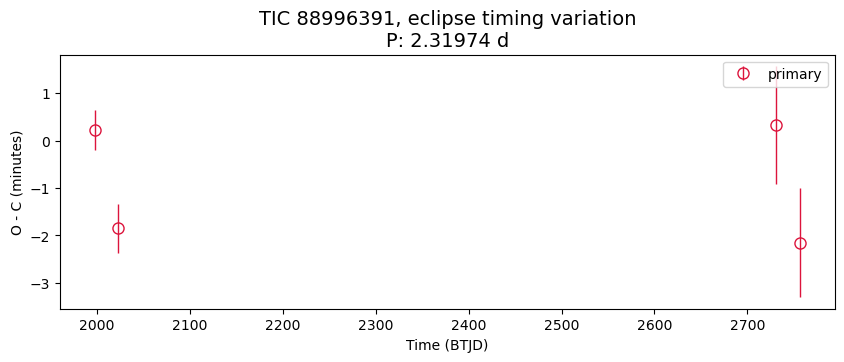

In [32]:
%matplotlib inline
# %matplotlib widget


title_suffix = "eclipse timing variation"

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

# in_df_primary = pd.read_csv(outfile_path)
from io import StringIO
in_df_primary = pd.read_csv(StringIO(etv_out_str))
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

# in_df_primary = in_df_primary[in_df_primary.std_mins < 10]  # filter out outliers in error
# print(f"Note: {len(in_df_primary_all) - len(in_df_primary)} data points in df_primary filtered out due to huge O-C error.")

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    # in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary = pd.read_csv(StringIO(etv_out_str_s))
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period_s)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period_s*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period_s*24*60
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful

    # in_df_secondary = in_df_secondary[in_df_secondary.std_mins < 10]  # filter out outliers in error
    # print(f"Note: {len(in_df_secondary_all) - len(in_df_secondary)} data points in in_df_secondary filtered out due to huge O-C error.")

    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, {title_suffix}\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.35)
# plt.ylim(-3, 8)
plt.show()

## ETV O-C plot (Per-cycle)

Note: 3 data points in df_primary filtered out due to large errors.


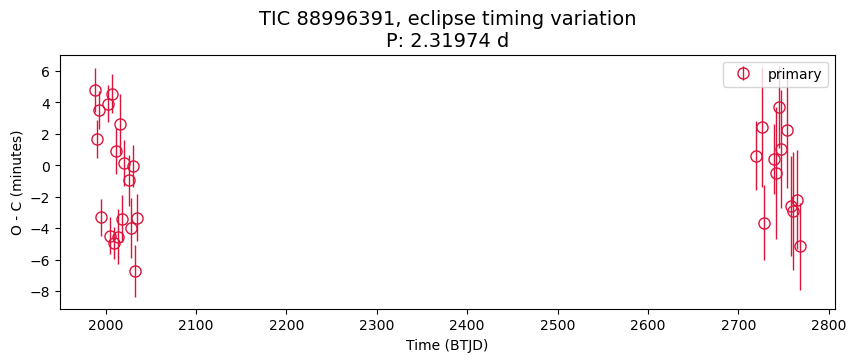

In [47]:
%matplotlib inline
# %matplotlib widget


title_suffix = "eclipse timing variation"

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

# in_df_primary = pd.read_csv(outfile_path)
from io import StringIO
in_df_primary = pd.read_csv(StringIO(c_etv_out_str))
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

in_df_primary = in_df_primary[in_df_primary.std_mins < 10]  # filter out outliers 
print(f"Note: {len(in_df_primary_all) - len(in_df_primary)} data points in df_primary filtered out due to large errors.")

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    # in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary = pd.read_csv(StringIO(c_etv_out_str_s))
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period_s)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period_s*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period_s*24*60
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful

    in_df_secondary = in_df_secondary[in_df_secondary.std_mins < 10]  # filter out outliers in 
    print(f"Note: {len(in_df_secondary_all) - len(in_df_secondary)} data points in in_df_secondary filtered out due to lager errors.")

    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, {title_suffix}\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.35)
# plt.ylim(-3, 8)
plt.show()

### O-C Plot, Zoom In (per cycle)

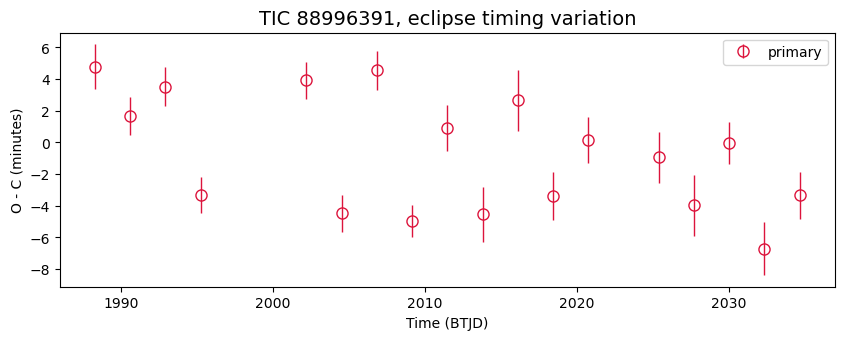

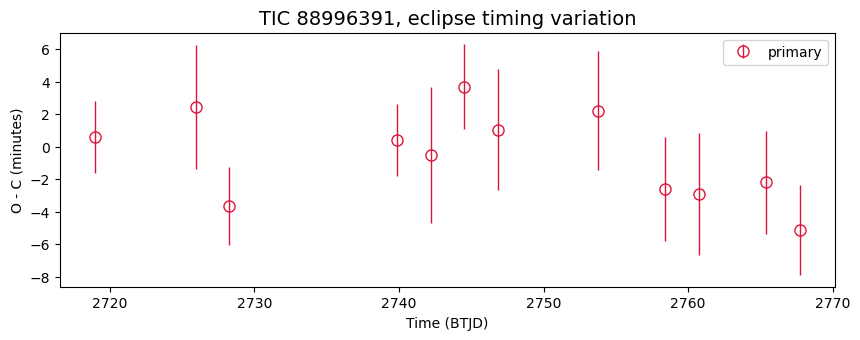

In [48]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1800, 2050),
    (2700, 2800),
]

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    # ax = axs_list[0][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    # ax = axs_list[1][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")

    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]

        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]

        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]

            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();

        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)

        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

In [ ]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')

plt.xlabel("period")

plt.legend()
# plt.xlim(0, 1000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))

    plt.plot(1/frequency, power, label = 'primary')

    if t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, label = 'secondary')

    plt.xlabel("period")

    plt.legend()
    plt.xlim(0, 100)
    plt.show()

## O-C plot, folded

- for periodic trend in O-C

In [ ]:
def truncate_freq_power_to_period_range(freq, power, period_min, period_max):
    f, p = freq, power
    if period_min is not None:
        f, p = f[f < 1 / period_min], p[f < 1 / period_min]
    if period_max is not None:
        f, p = f[f > 1 / period_max], p[f >  1 / period_max]
    return f, p


def plot_oc_folded(period_min=None, period_max=None, period_min_s=None, period_max_s=None, period=None, period_s=None):

    if period is None:
        _f, _p = truncate_freq_power_to_period_range(frequency, power, period_min, period_max)
        period = 1 / _f[np.argmax(_p)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=12**2, c=in_df_primary.epoch);
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'None', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period:.4f} d", fontsize=14)

    if in_df_secondary is not None:
        if period_s is None:
            _f, _p = truncate_freq_power_to_period_range(frequency_s, power_s, period_min_s, period_max_s)
            period_s= 1 / _f[np.argmax(_p)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_s)
        axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'o',  s=12**2, c=in_df_secondary.epoch);
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color='None', ecolor='navy', markeredgecolor = 'None', label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_s:.4f} d", fontsize=14)

    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (Normalized)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    return axs

In [ ]:
%matplotlib inline
# %matplotlib widget

if False:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    def tweak_axs(axs):
        pass

    axs = plot_oc_folded(
        period_min=None, period_max=None,
        period_min_s=None, period_max_s=None
    )
    tweak_axs(axs)

## Results Summary

In [50]:
# FILL-IN the ETV results / comments
has_etv = "N?"
comments = "O-C shows only scatter. But if there were ETV with ~246 d period (Gaia DR3 NSS), it would not have been obsered, as the data is spaced by about 3x 246 d."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1_a * 100, 2)  # use the deep one
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True,
))

0
tic                                                                                                                                                           88996391
has_etv                                                                                                                                                             N?
comments     O-C shows only scatter. But if there were ETV with ~246 d period (Gaia DR3 NSS), it would not have been obsered, as the data is spaced by about 3x 246 d.
period                                                                                                                                                         2.31974
depth_pct_p                                                                                                                                                       1.96
depth_pct_s                                                                                                                                                       None
epoch_p                                                                                                                                                       1985.949
epoch_s                                                                                                                                                           None
num_sectors                                                                                                                                                          4
time_span                                                                                                                                                       785.34
time_start                                                                                                                                                     1983.64
time_end                                                                                                                                                       2768.98


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
88996391,N?,"O-C shows only scatter. But if there were ETV with ~246 d period (Gaia DR3 NSS), it would not have been obsered, as the data is spaced by about 3x 246 d.",2.31974,1.96,,1985.949,,4,785.34,1983.64,2768.98



## Scratch